<a href="https://colab.research.google.com/github/travislatchman/TheHearts/blob/main/Cardiac_Segmentation_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import os
import torch
import librosa
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import scipy.signal as signal
from scipy.signal import butter, lfilter
from collections import defaultdict
import sklearn.model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio, display


seed = 1
np.random.seed(seed)
rng = np.random.default_rng(seed) # seeded random number generator

### example placeholder for an audio file

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
def load_audio_file(file_path):
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    return audio_data, sample_rate

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def apply_lowpass_filter(audio_data, sample_rate, cutoff=195):
    filtered_data = butter_lowpass_filter(audio_data, cutoff, sample_rate)
    return filtered_data

def perform_fft(filtered_data):
    fft_data = np.fft.fft(filtered_data)
    return fft_data

In [36]:
class HeartSoundDataset(Dataset):
    def __init__(self, file_paths, labels=None, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        audio_data, sample_rate = load_audio_file(file_path)
        filtered_data = apply_lowpass_filter(audio_data, sample_rate)
        fft_data = perform_fft(filtered_data)

        # Use only the real part of the FFT data
        real_fft_data = np.real(fft_data)

        # Normalize data
        normalized_data = (real_fft_data - np.min(real_fft_data)) / (np.max(real_fft_data) - np.min(real_fft_data))

        if self.transform:
            normalized_data = self.transform(normalized_data)

        if self.labels is not None:
            label = self.labels[idx]
            return normalized_data, label
        else:
            return normalized_data


In [37]:
def create_dataloaders(file_paths, labels, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, batch_size=16, rng=None):
    dataset_size = len(file_paths)
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    dataset = HeartSoundDataset(file_paths, labels)
    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size], generator = rng)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

In [38]:
# Load audio file
label_encoder = LabelEncoder()
file_paths = []
labels = []
data_dir = "/content/drive/MyDrive/MLMA Group/CardiacData/DatasetB/"
# data_dir = "/content/drive/MyDrive/MLMA Group/CardiacData/physionet cardiac sounds/heart_sound/train"

for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    for file_name in os.listdir(label_dir):
      if file_name[-4:] == ".wav":
        file_paths.append(os.path.join(label_dir, file_name))
        labels.append(label)

# encoded_labels = label_encoder.fit_transform(labels)
# train_loader, val_loader, test_loader = create_dataloaders(file_paths, encoded_labels, rng=rng)

paths_train, paths_test, labels_train, labels_test = sklearn.model_selection.train_test_split(file_paths, labels, train_size=0.7, random_state=seed)
paths_val, paths_test, labels_val, labels_test = sklearn.model_selection.train_test_split(paths_test, labels_test, test_size=0.5, random_state=seed)

In [39]:
def noise_reduction(audio_signal, sample_rate, noise_window_duration=0.5):
    window_size = sample_rate // 10
    overlap = window_size // 2
    noise_window_size = int(noise_window_duration * sample_rate)

    # Calculate the spectrogram of the input signal
    _, _, stft = signal.stft(audio_signal, fs=sample_rate, nperseg=window_size, noverlap=overlap)

    # Calculate the average noise profile within the noise window
    noise_profile = np.mean(np.abs(stft[:, :noise_window_size])**2, axis=1)
    noise_profile = np.sqrt(noise_profile)

    # Perform spectral subtraction to reduce noise
    stft_noise_reduced = stft - noise_profile[:, np.newaxis]
    stft_noise_reduced = np.maximum(stft_noise_reduced, 0)

    # Compute the inverse STFT to obtain the denoised signal
    _, denoised_signal = signal.istft(stft_noise_reduced, fs=sample_rate, nperseg=window_size, noverlap=overlap)

    return denoised_signal

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (0):


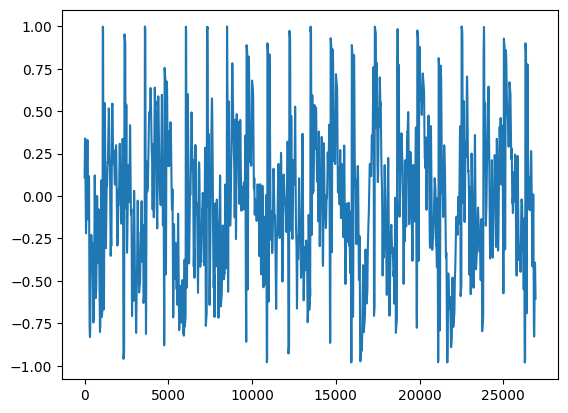

filtered audio (apply_lowpass_filter(); image 0):


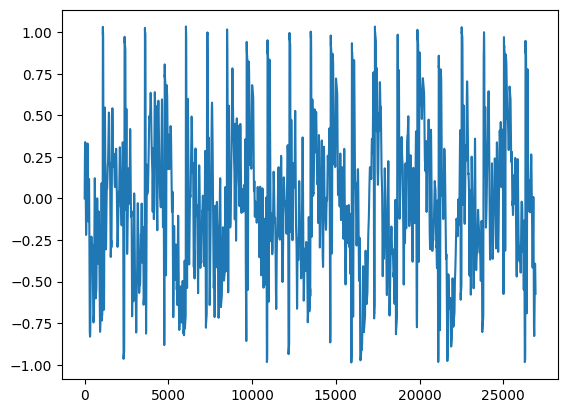

filtered audio (noise_reduction(); image 0):


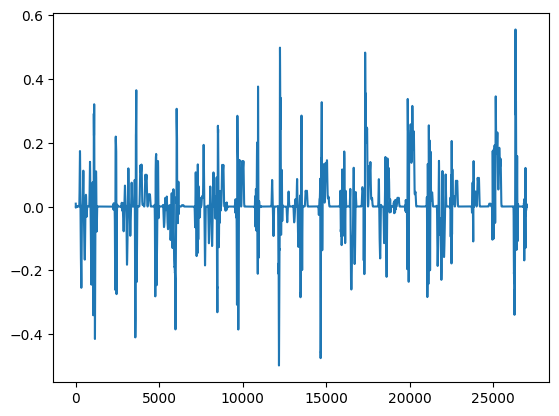

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (1):


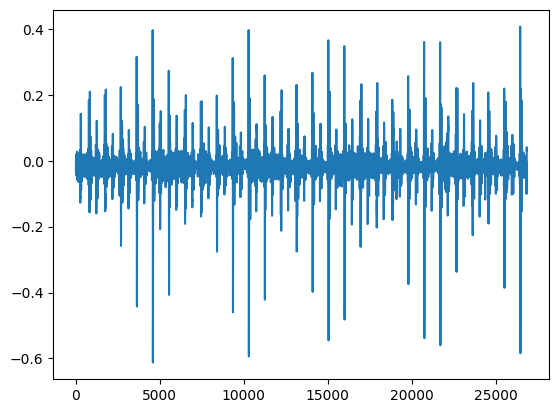

filtered audio (apply_lowpass_filter(); image 1):


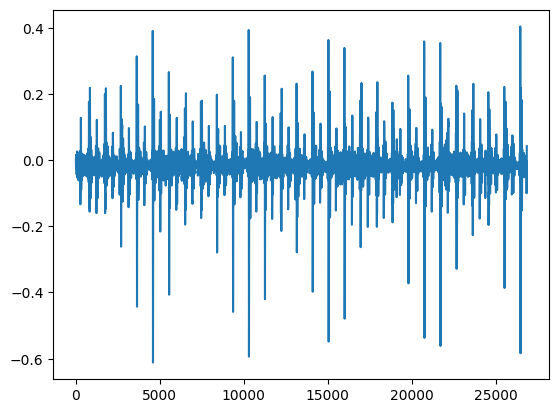

filtered audio (noise_reduction(); image 1):


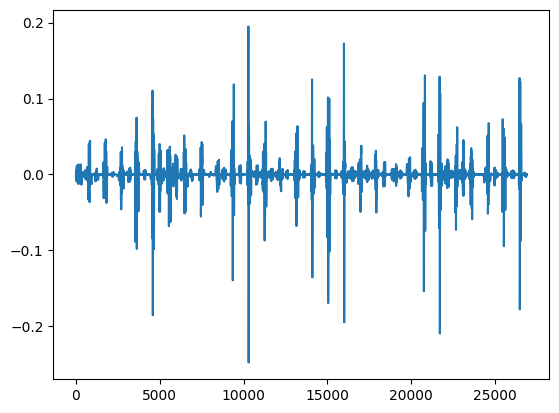

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (2):


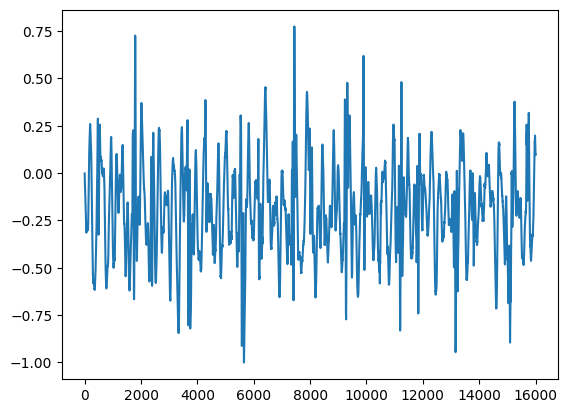

filtered audio (apply_lowpass_filter(); image 2):


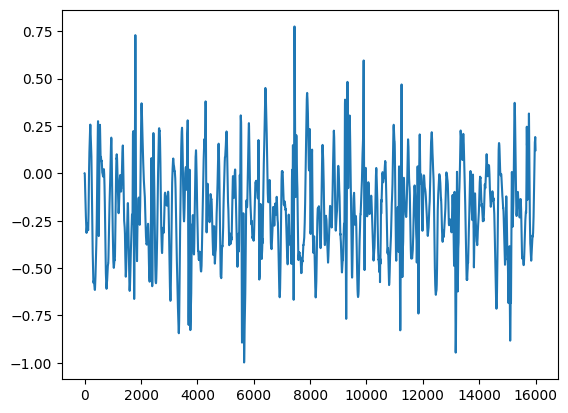

filtered audio (noise_reduction(); image 2):


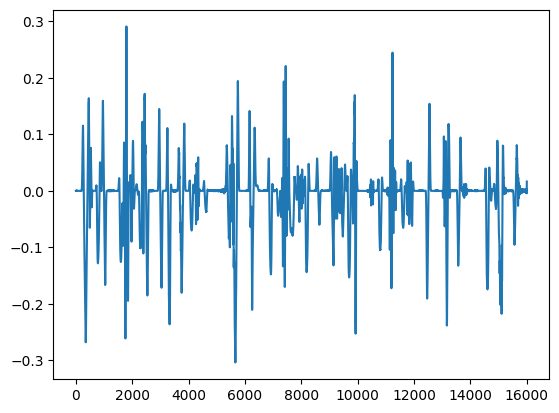

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (3):


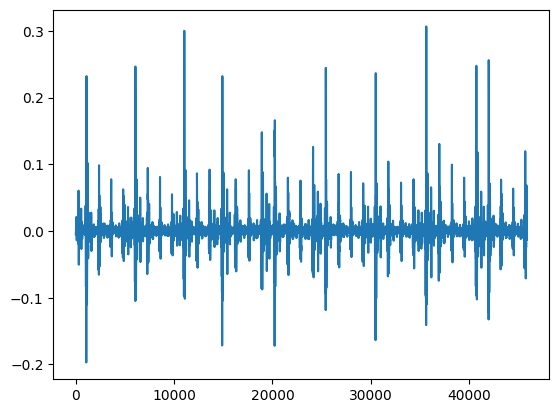

filtered audio (apply_lowpass_filter(); image 3):


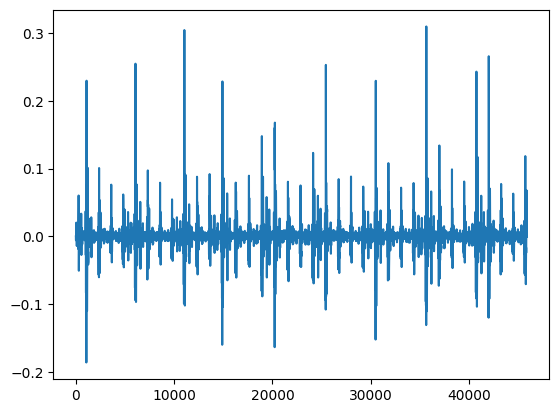

filtered audio (noise_reduction(); image 3):


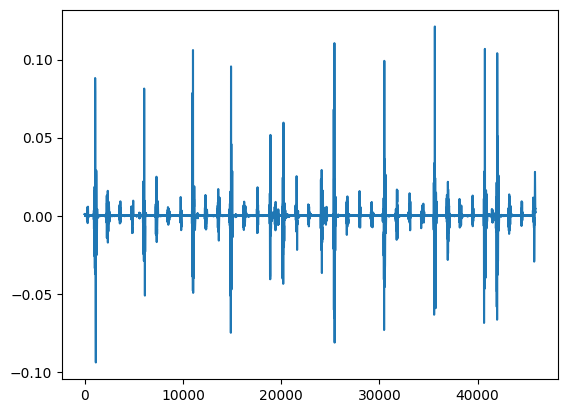

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (4):


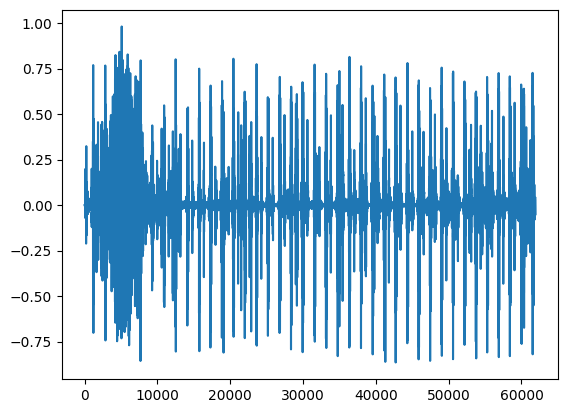

filtered audio (apply_lowpass_filter(); image 4):


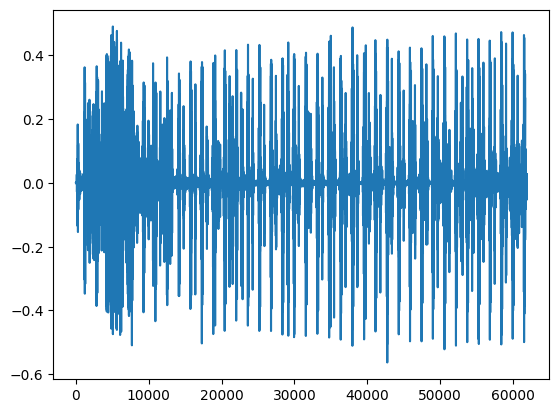

filtered audio (noise_reduction(); image 4):


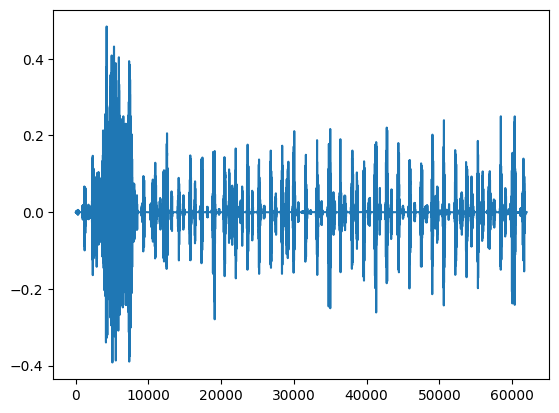

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (5):


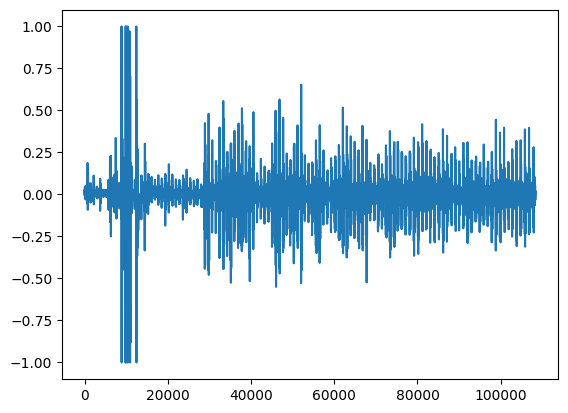

filtered audio (apply_lowpass_filter(); image 5):


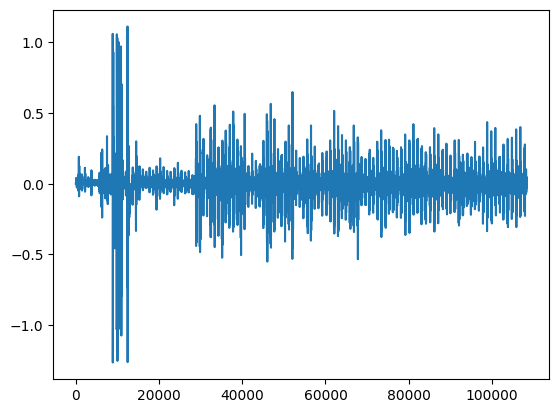

filtered audio (noise_reduction(); image 5):


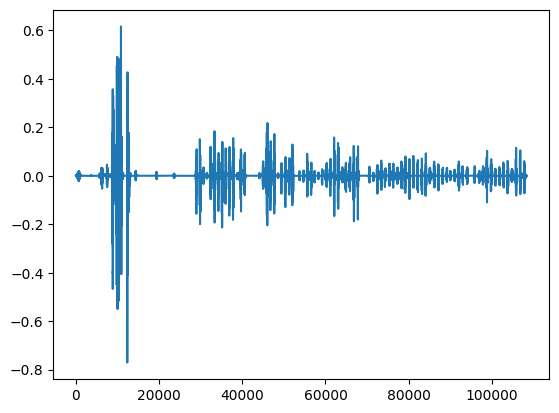

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (6):


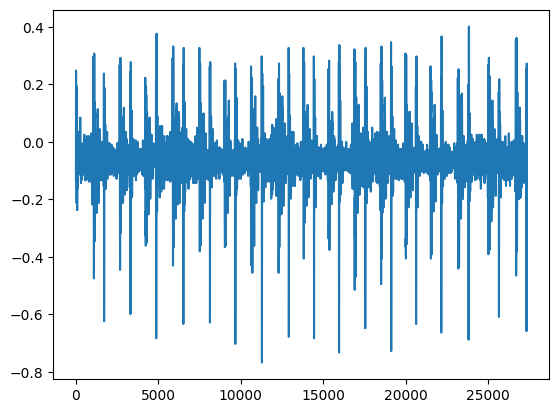

filtered audio (apply_lowpass_filter(); image 6):


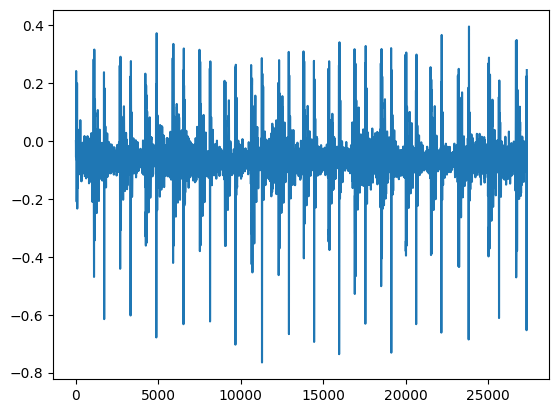

filtered audio (noise_reduction(); image 6):


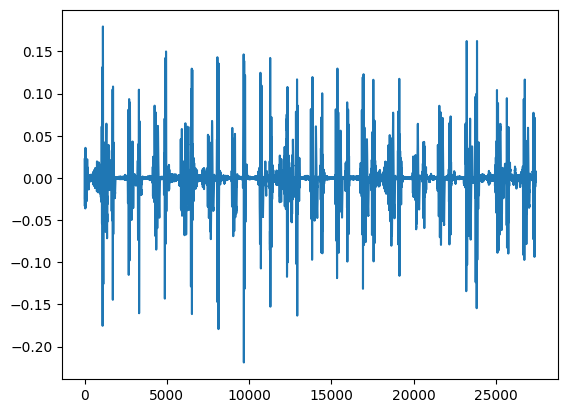

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (7):


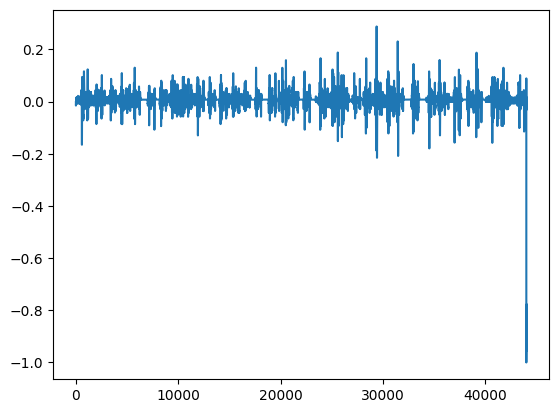

filtered audio (apply_lowpass_filter(); image 7):


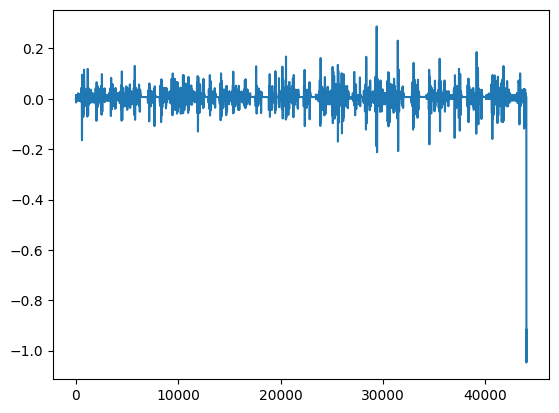

filtered audio (noise_reduction(); image 7):


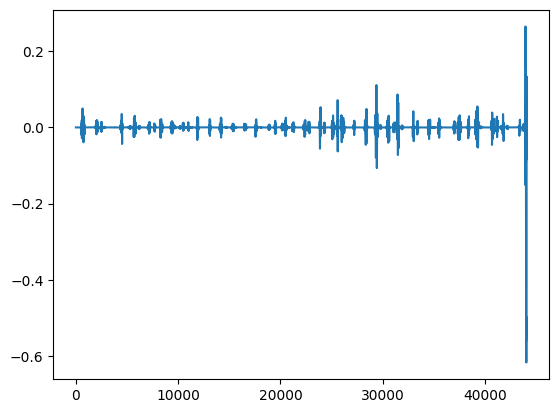

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (8):


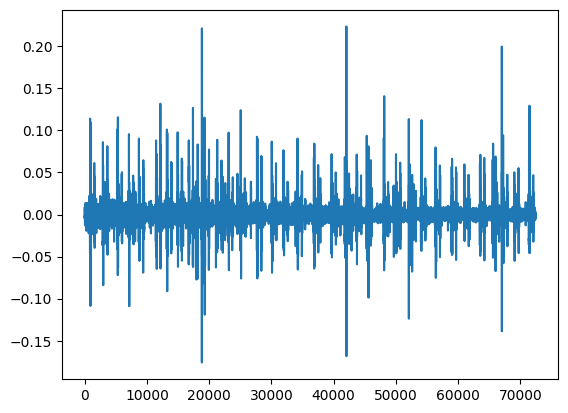

filtered audio (apply_lowpass_filter(); image 8):


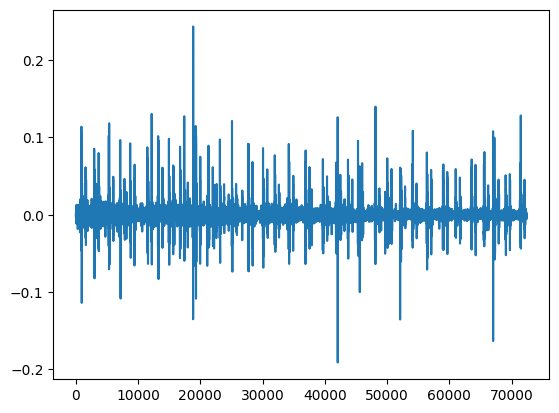

filtered audio (noise_reduction(); image 8):


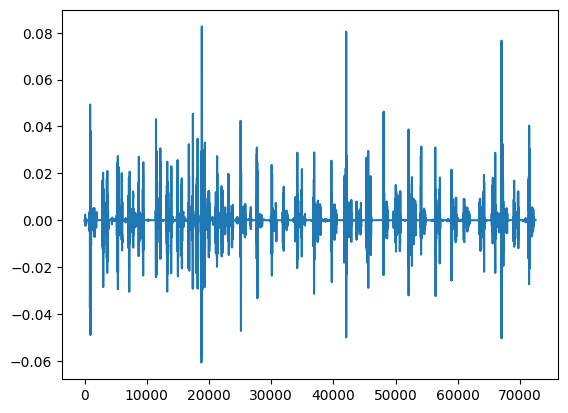

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (9):


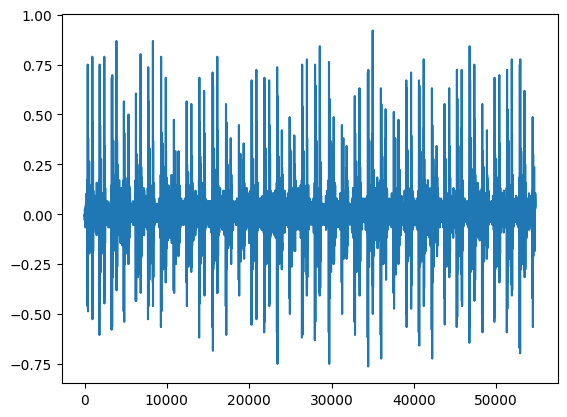

filtered audio (apply_lowpass_filter(); image 9):


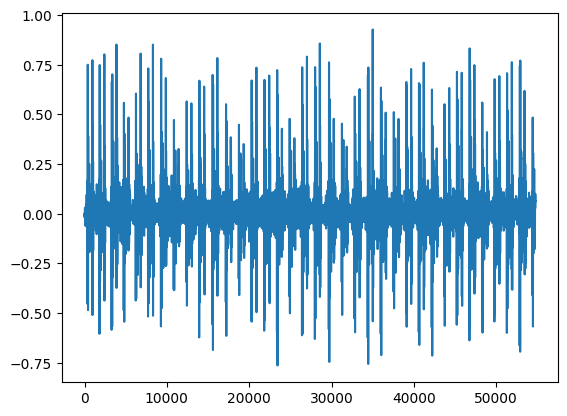

filtered audio (noise_reduction(); image 9):


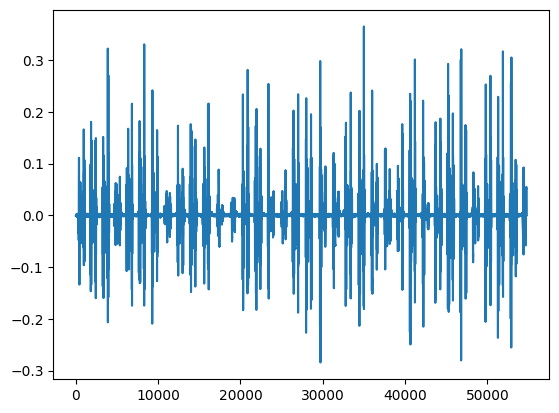

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (10):


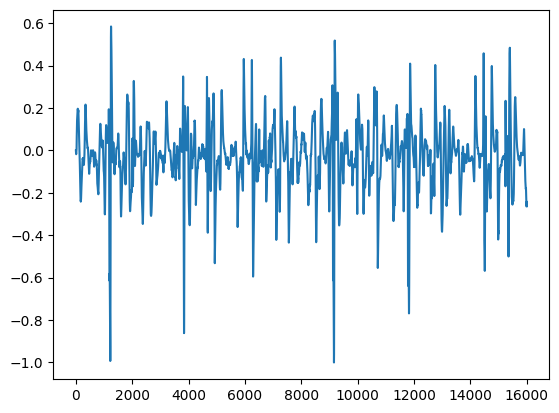

filtered audio (apply_lowpass_filter(); image 10):


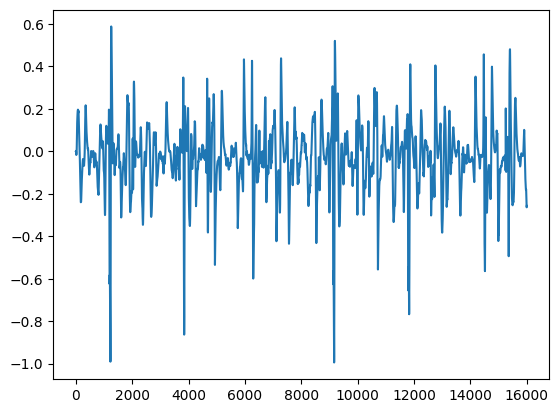

filtered audio (noise_reduction(); image 10):


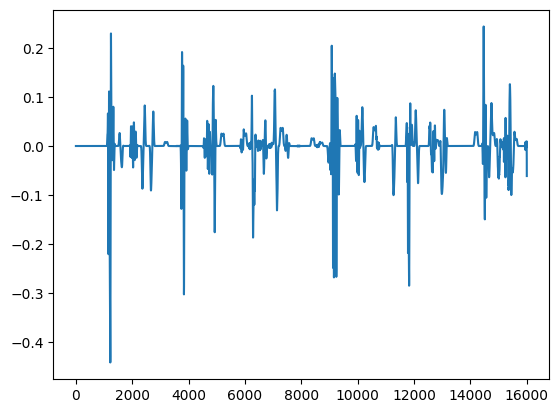

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (11):


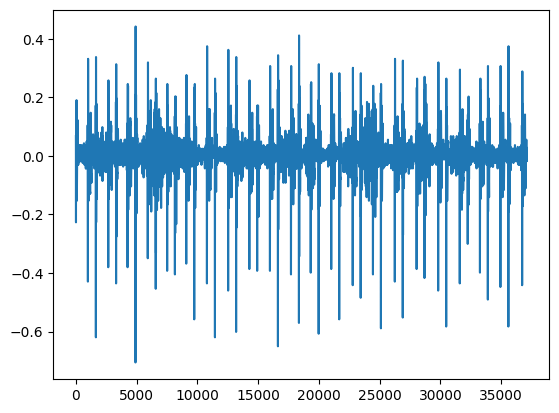

filtered audio (apply_lowpass_filter(); image 11):


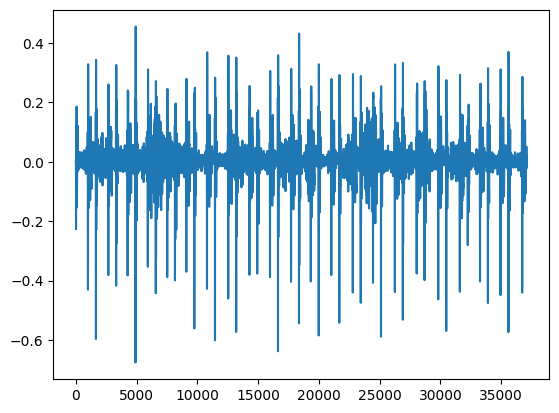

filtered audio (noise_reduction(); image 11):


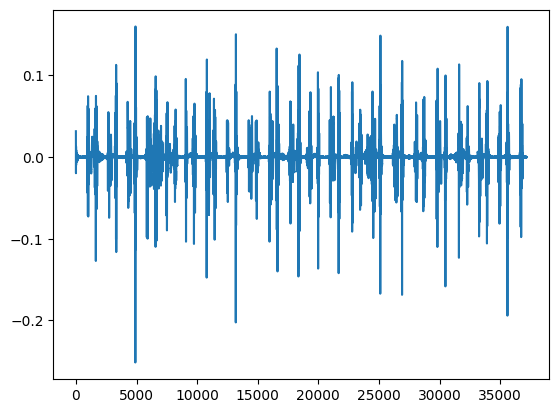

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (12):


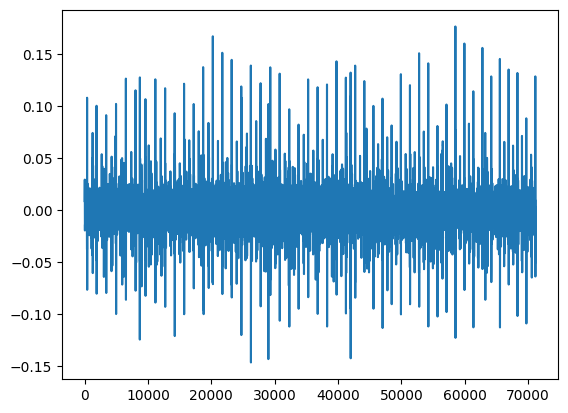

filtered audio (apply_lowpass_filter(); image 12):


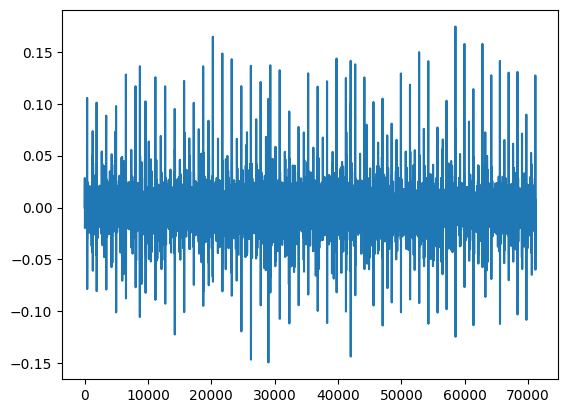

filtered audio (noise_reduction(); image 12):


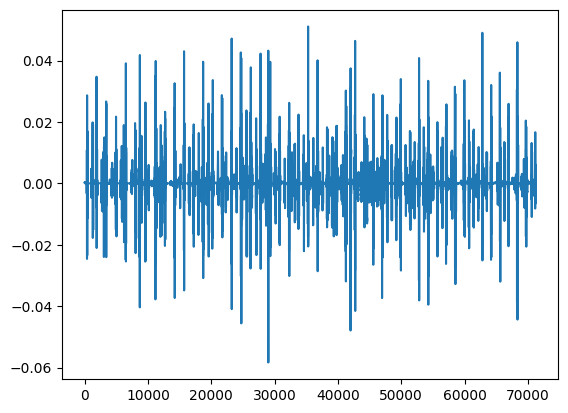

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (13):


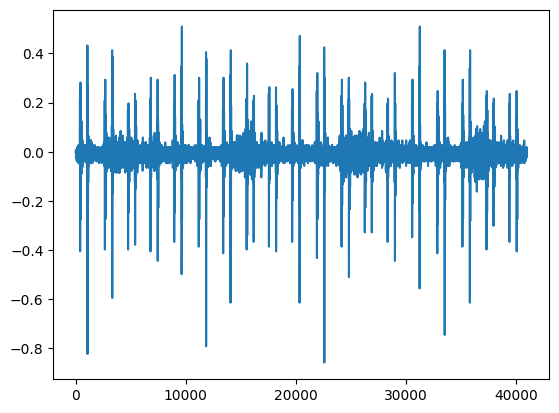

filtered audio (apply_lowpass_filter(); image 13):


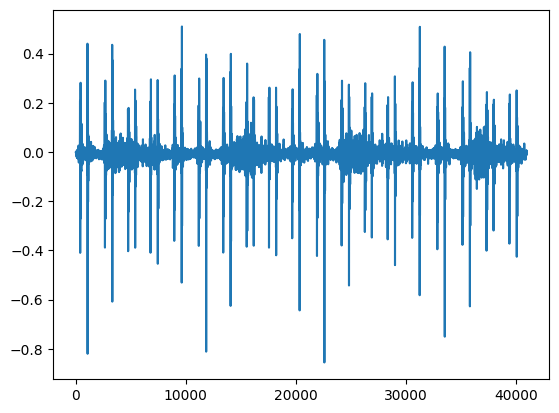

filtered audio (noise_reduction(); image 13):


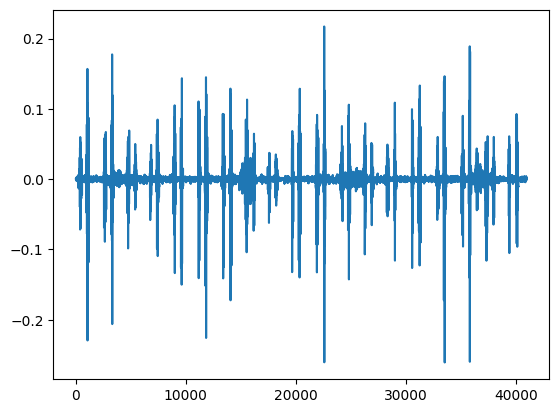

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (14):


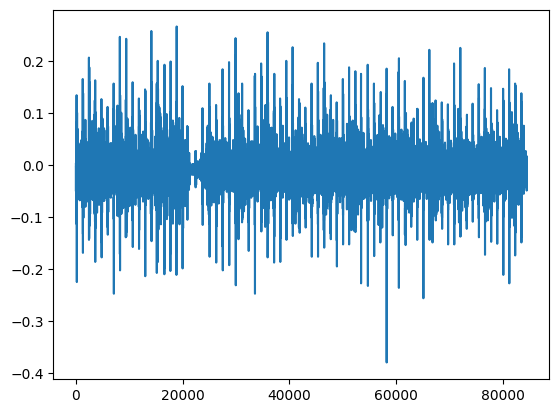

filtered audio (apply_lowpass_filter(); image 14):


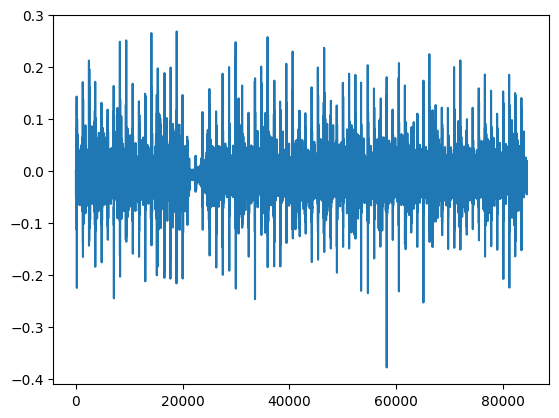

filtered audio (noise_reduction(); image 14):


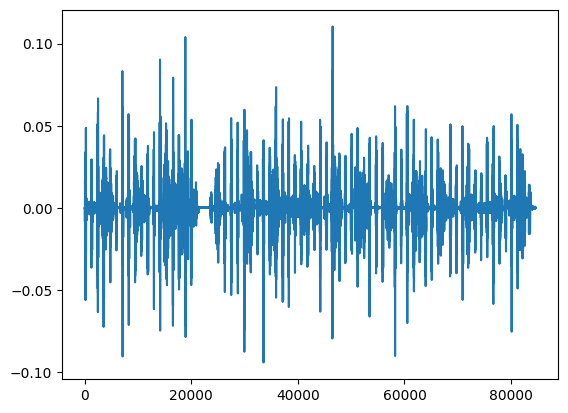

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (15):


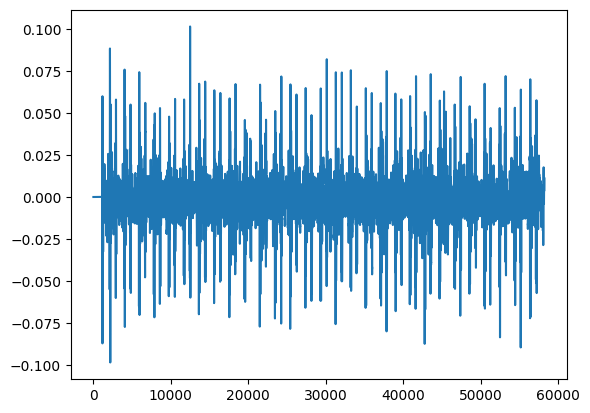

filtered audio (apply_lowpass_filter(); image 15):


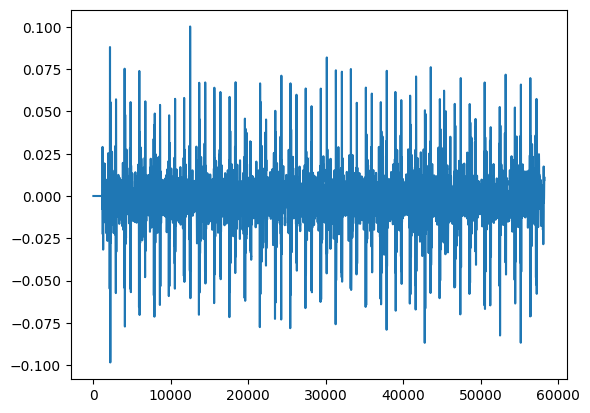

filtered audio (noise_reduction(); image 15):


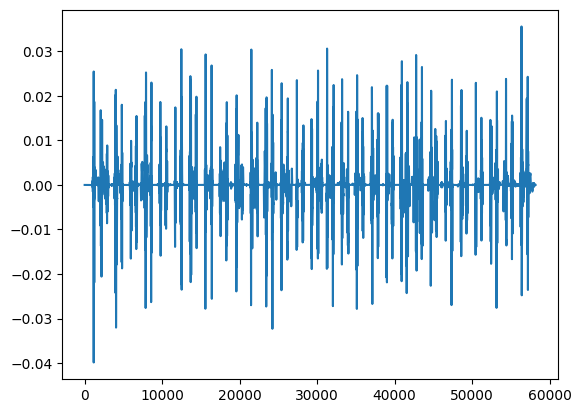

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (16):


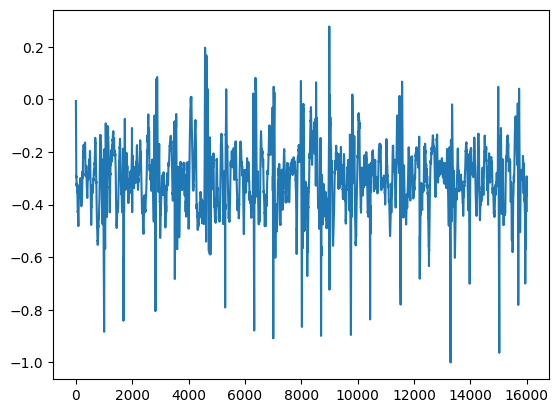

filtered audio (apply_lowpass_filter(); image 16):


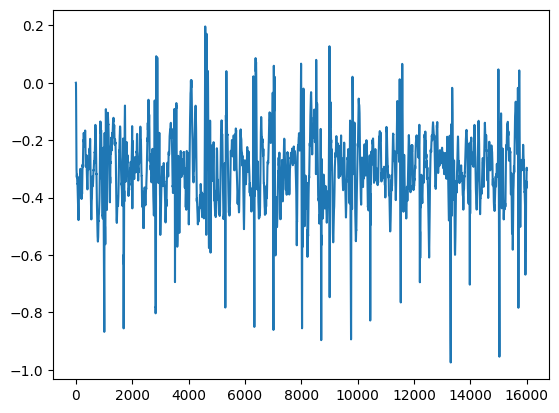

filtered audio (noise_reduction(); image 16):


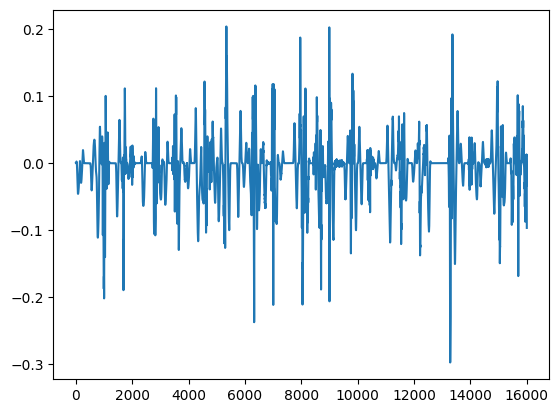

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (17):


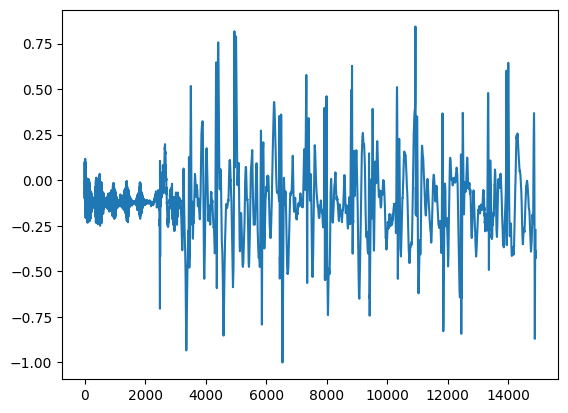

filtered audio (apply_lowpass_filter(); image 17):


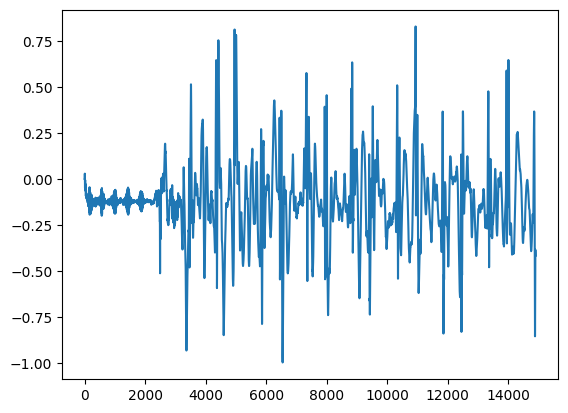

filtered audio (noise_reduction(); image 17):


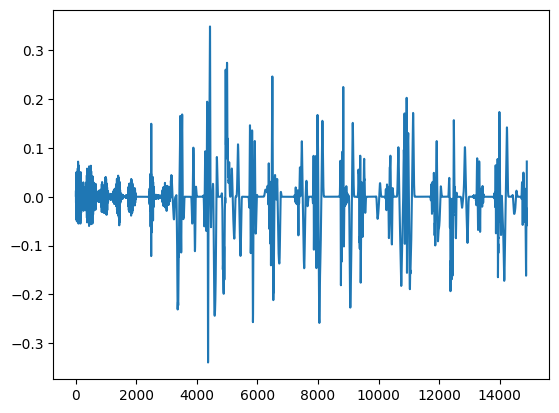

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (18):


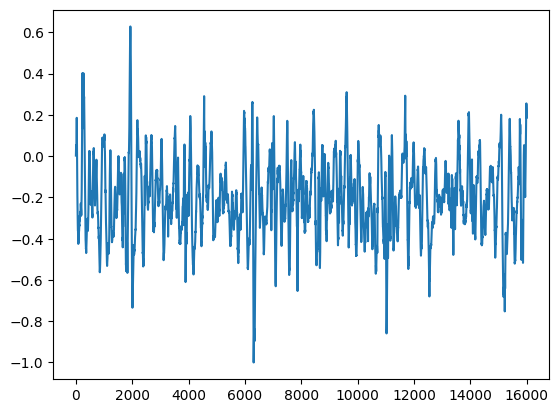

filtered audio (apply_lowpass_filter(); image 18):


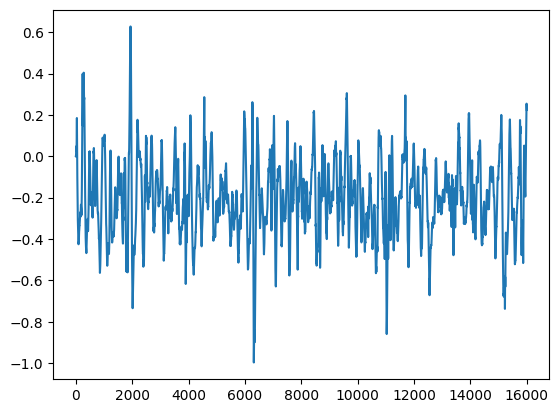

filtered audio (noise_reduction(); image 18):


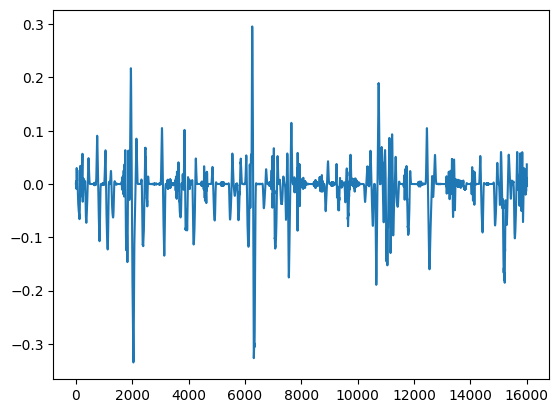

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (19):


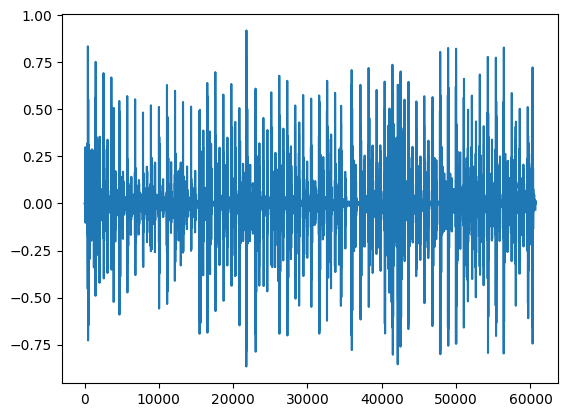

filtered audio (apply_lowpass_filter(); image 19):


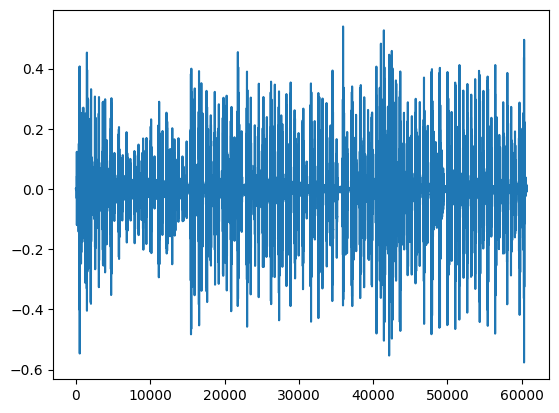

filtered audio (noise_reduction(); image 19):


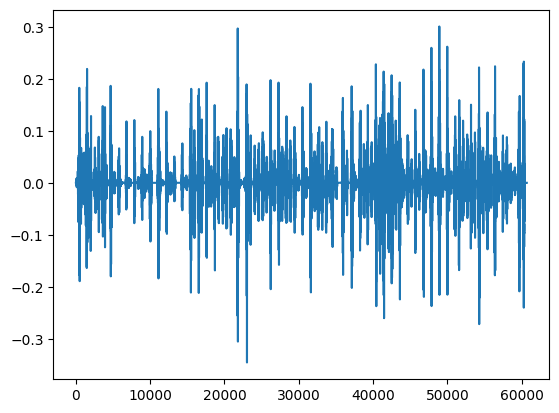

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (20):


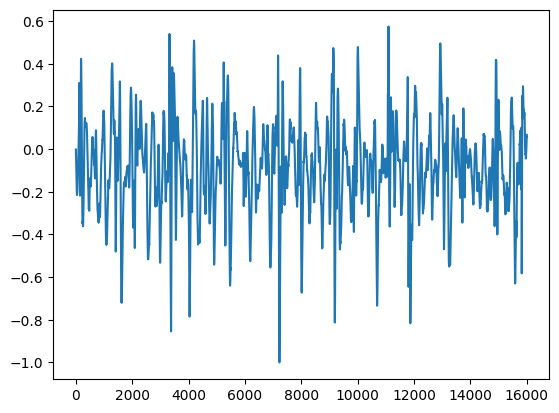

filtered audio (apply_lowpass_filter(); image 20):


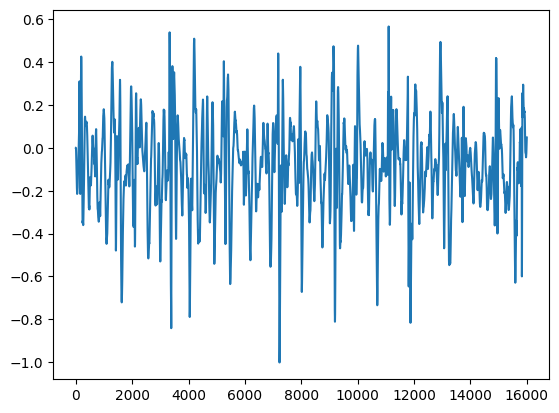

filtered audio (noise_reduction(); image 20):


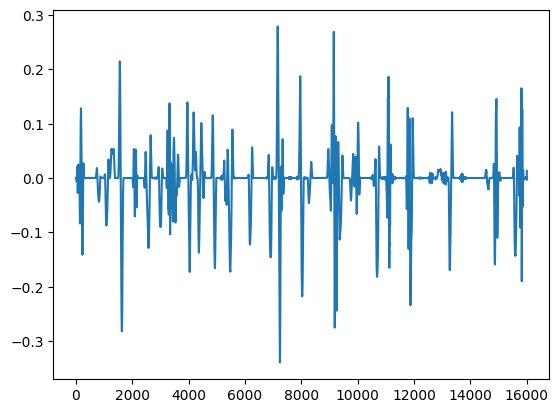

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (21):


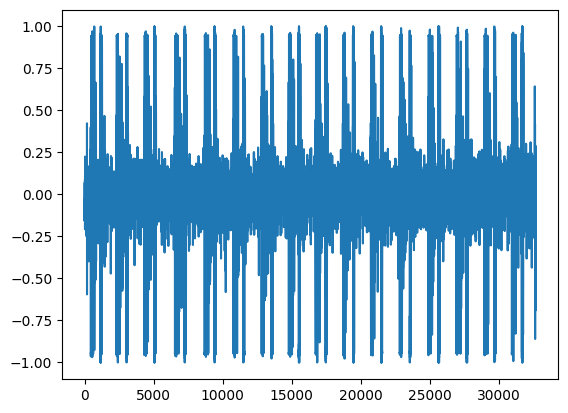

filtered audio (apply_lowpass_filter(); image 21):


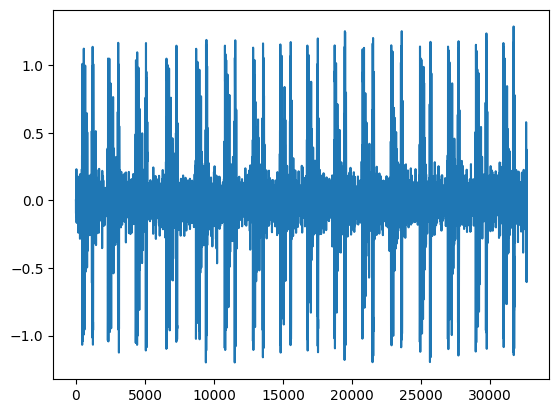

filtered audio (noise_reduction(); image 21):


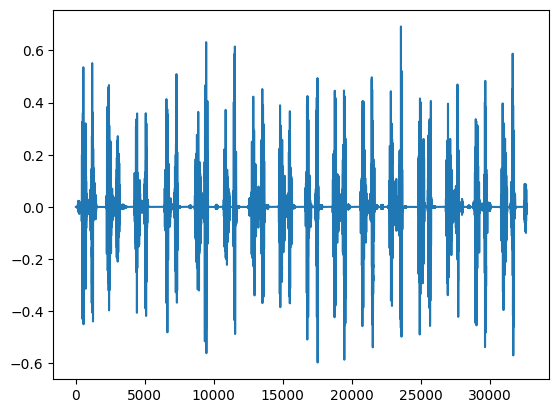

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (22):


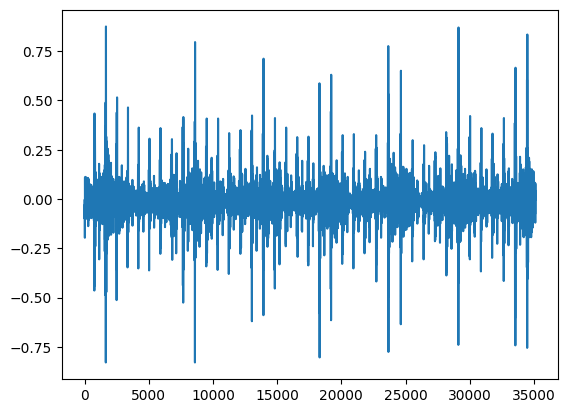

filtered audio (apply_lowpass_filter(); image 22):


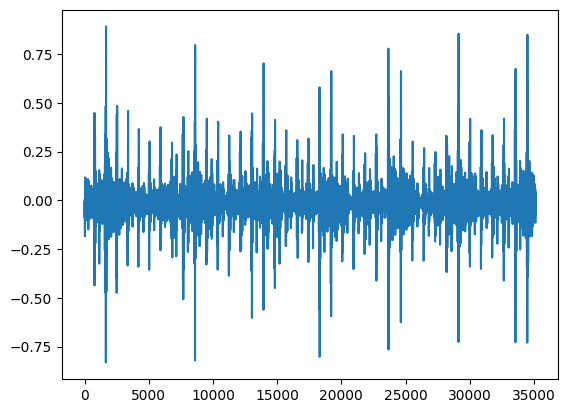

filtered audio (noise_reduction(); image 22):


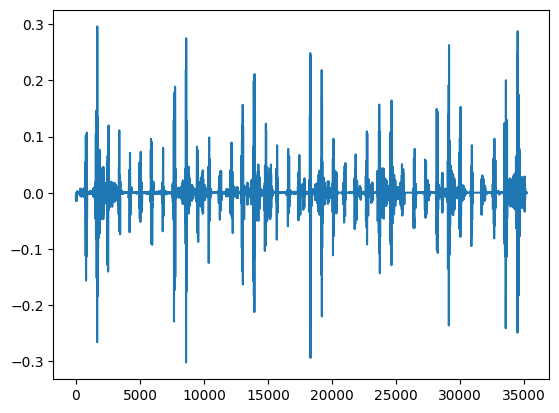

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (23):


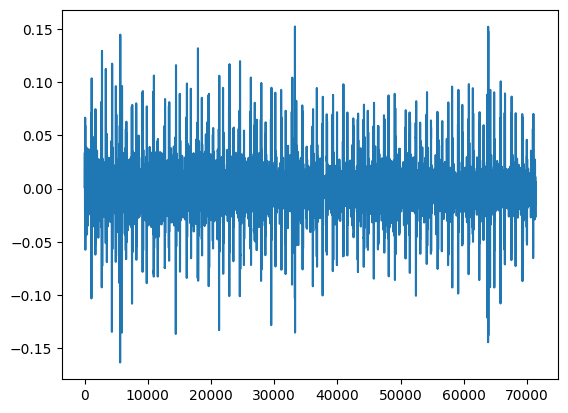

filtered audio (apply_lowpass_filter(); image 23):


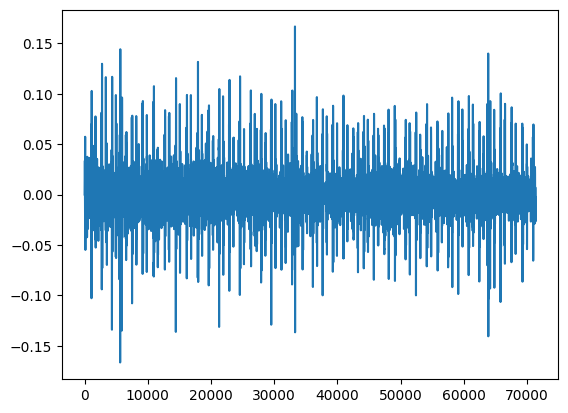

filtered audio (noise_reduction(); image 23):


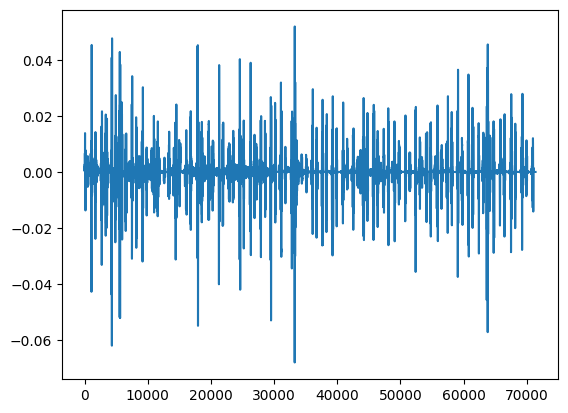

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (24):


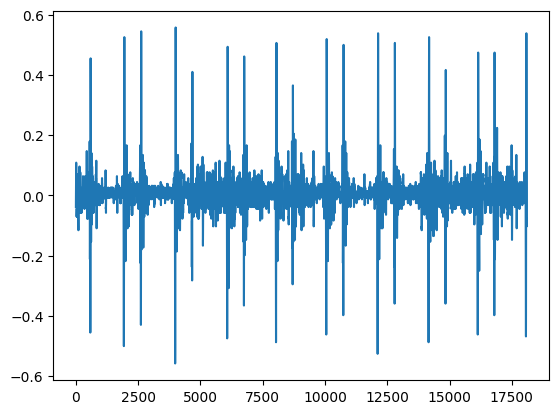

filtered audio (apply_lowpass_filter(); image 24):


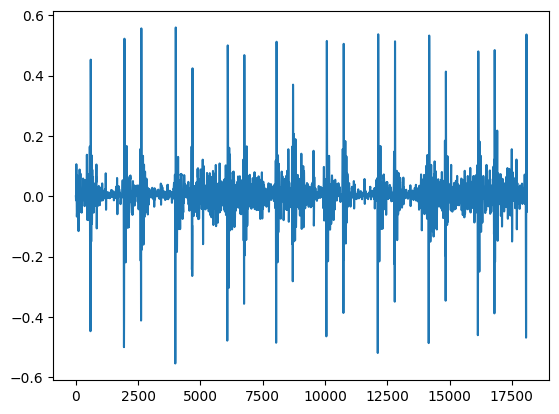

filtered audio (noise_reduction(); image 24):


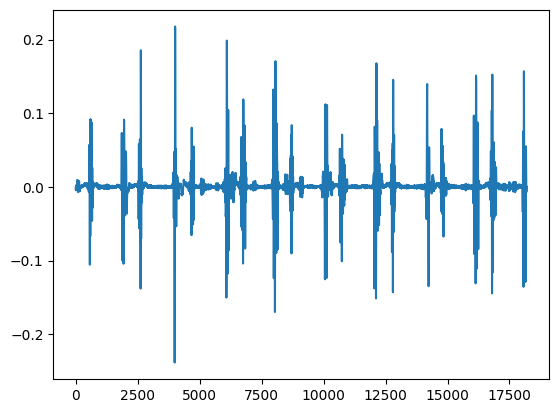

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (25):


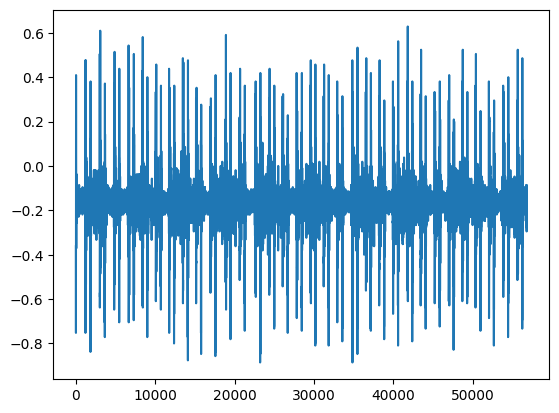

filtered audio (apply_lowpass_filter(); image 25):


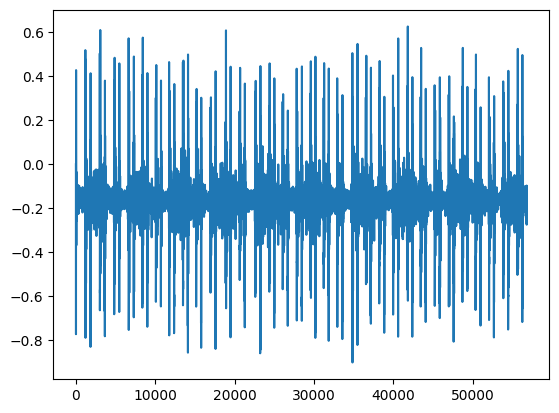

filtered audio (noise_reduction(); image 25):


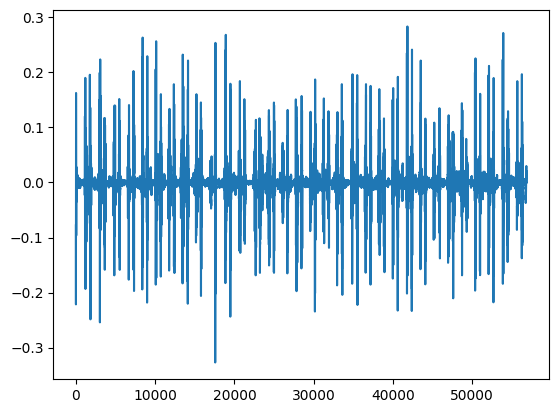

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (26):


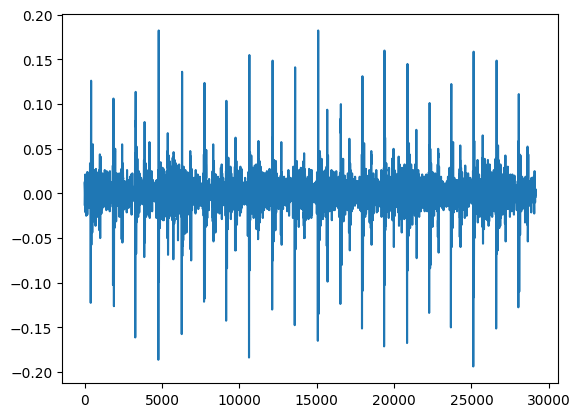

filtered audio (apply_lowpass_filter(); image 26):


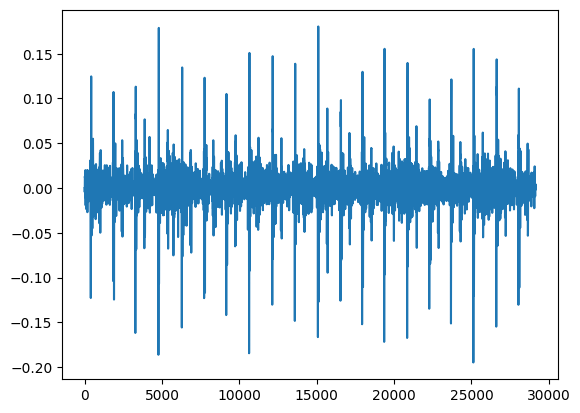

filtered audio (noise_reduction(); image 26):


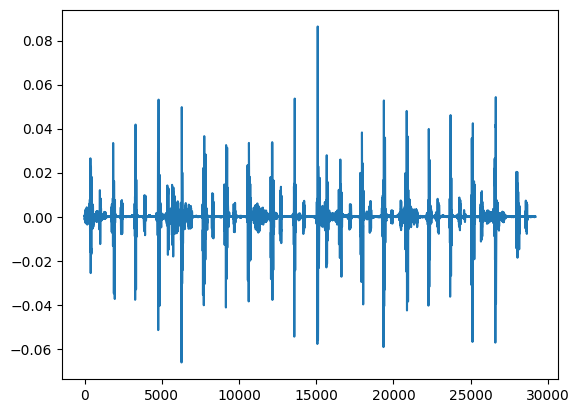

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (27):


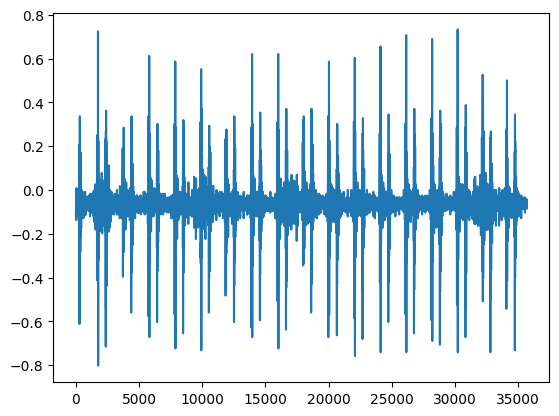

filtered audio (apply_lowpass_filter(); image 27):


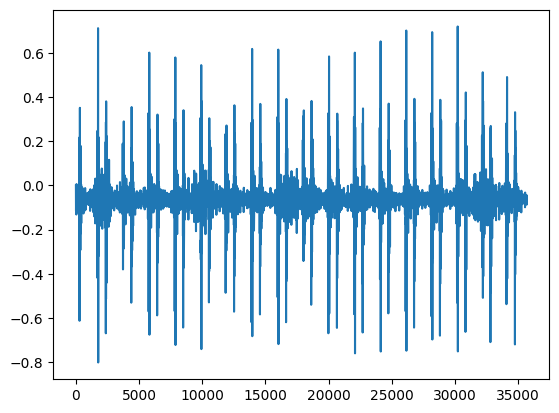

filtered audio (noise_reduction(); image 27):


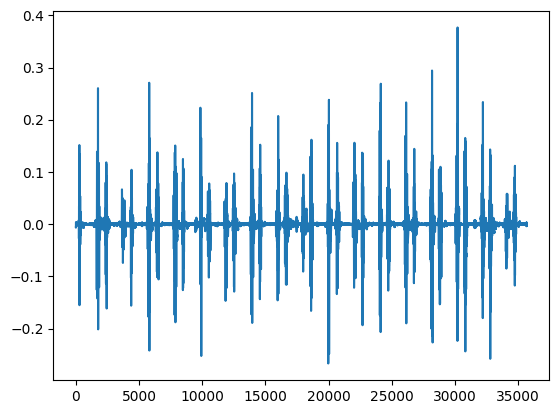

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (28):


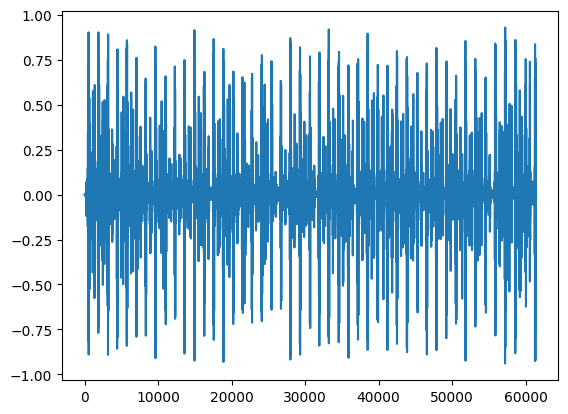

filtered audio (apply_lowpass_filter(); image 28):


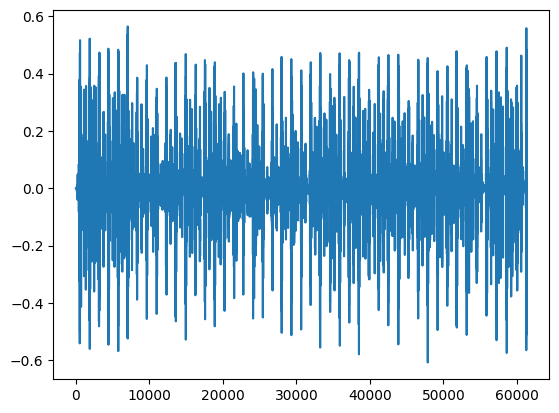

filtered audio (noise_reduction(); image 28):


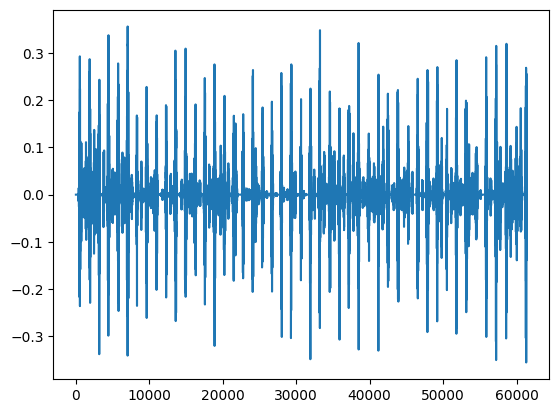

PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS
unfiltered audio (29):


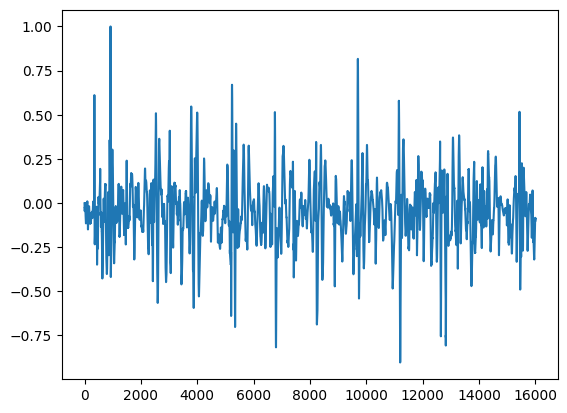

filtered audio (apply_lowpass_filter(); image 29):


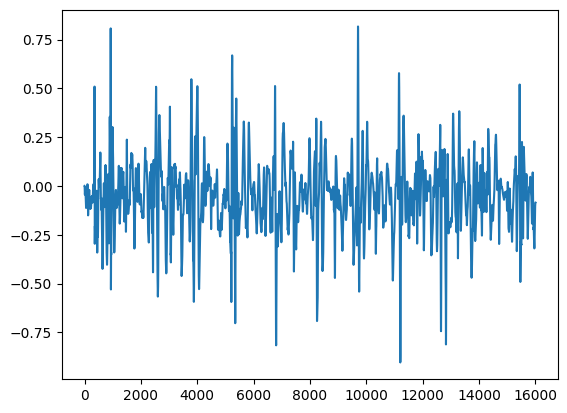

filtered audio (noise_reduction(); image 29):


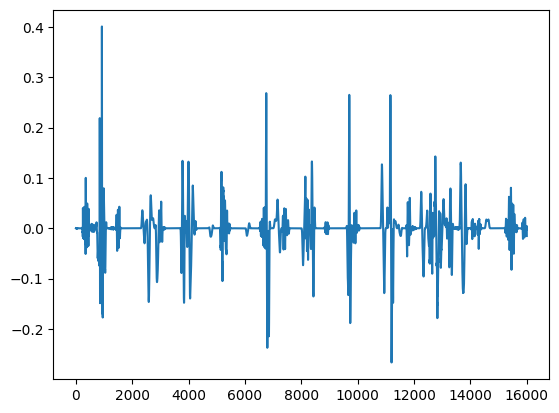

In [32]:
#### PHYSIONET DATA, UNFILTERED AND FILTERED DATA
for i, signal_path in enumerate(paths_train[:30]):
  audio_data, sample_rate = librosa.load(signal_path, sr=None)
  filtered_audio = apply_lowpass_filter(audio_data, sample_rate)
  # plt.scatter(np.arange(len(audio_data))//sample_rate, audio_data)
  print("PHYSIONET DATA, UNFILTERED AND FILTERED PLOTS")
  print(f"unfiltered audio ({i}):")
  plt.plot(audio_data)
  plt.show()
  print(f"filtered audio (apply_lowpass_filter(); image {i}):")
  plt.plot(filtered_audio)
  plt.show()
  print(f"filtered audio (noise_reduction(); image {i}):")
  plt.plot(noise_reduction(audio_data, sample_rate))
  plt.show()

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (0):


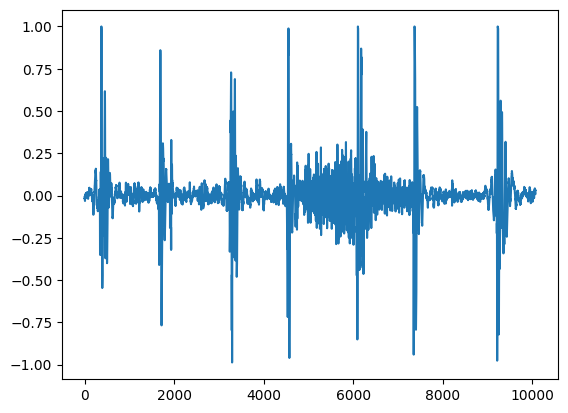

filtered audio (0):


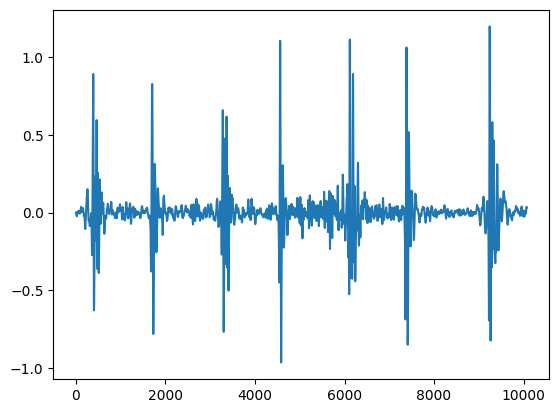

filtered audio (noise_reduction(); image 0):


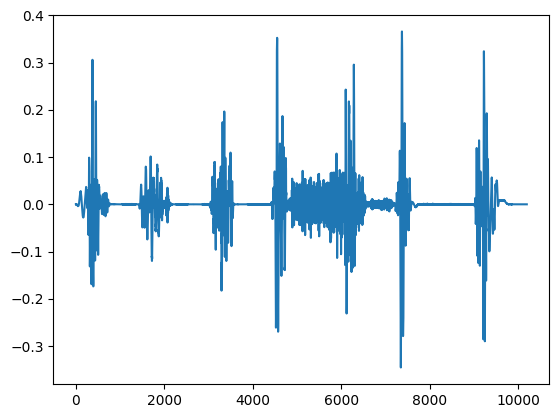

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (1):


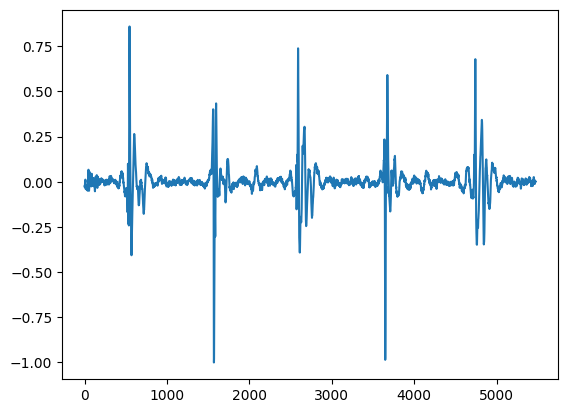

filtered audio (1):


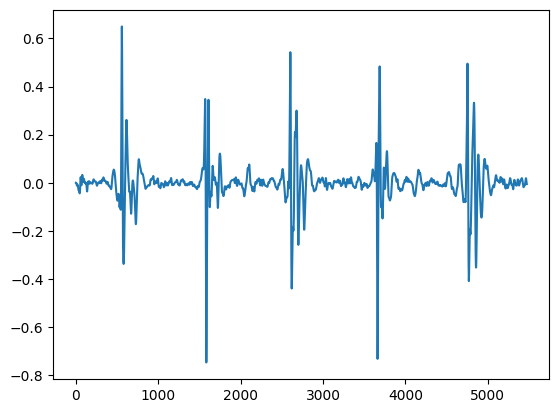

filtered audio (noise_reduction(); image 1):


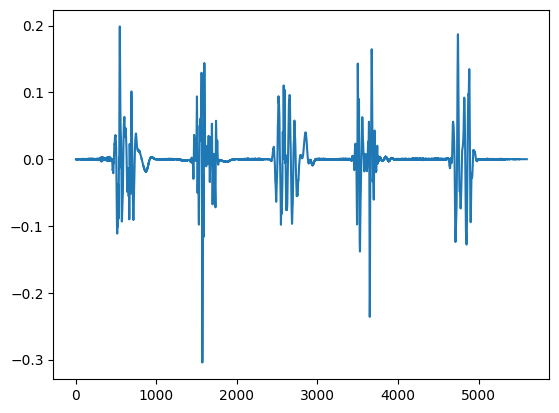

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (2):


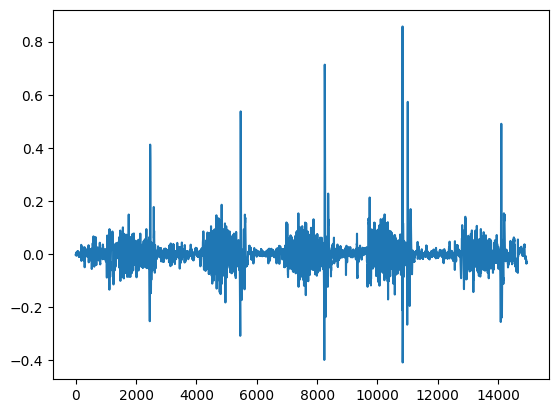

filtered audio (2):


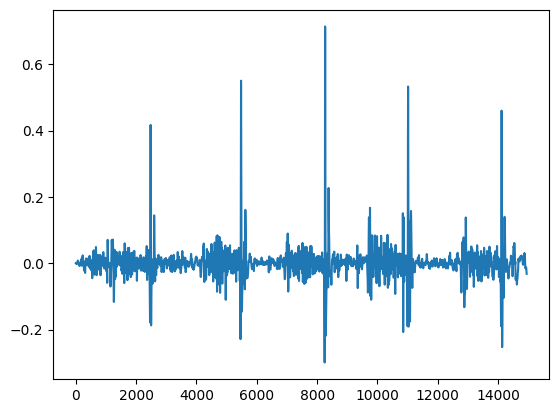

filtered audio (noise_reduction(); image 2):


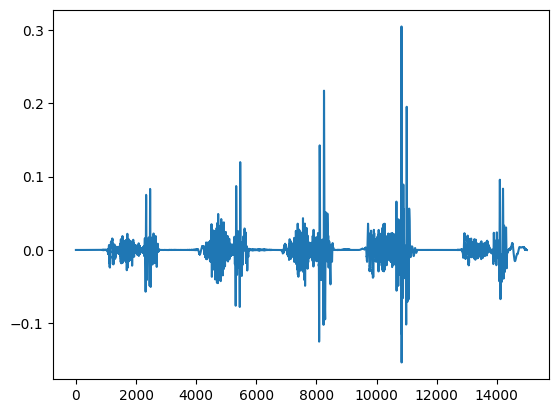

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (3):


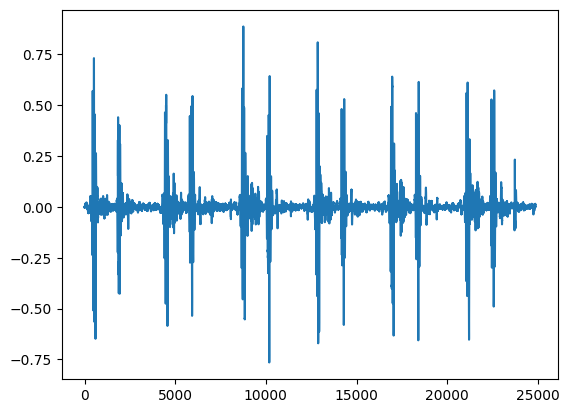

filtered audio (3):


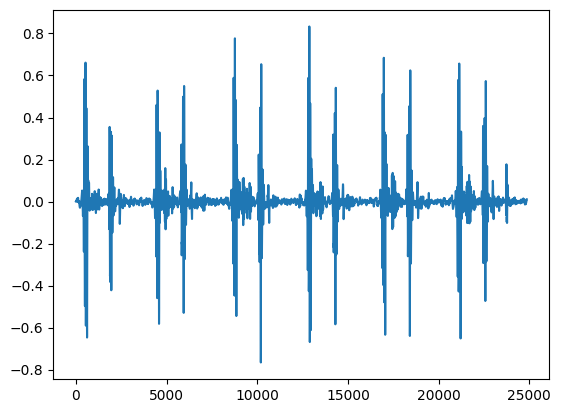

filtered audio (noise_reduction(); image 3):


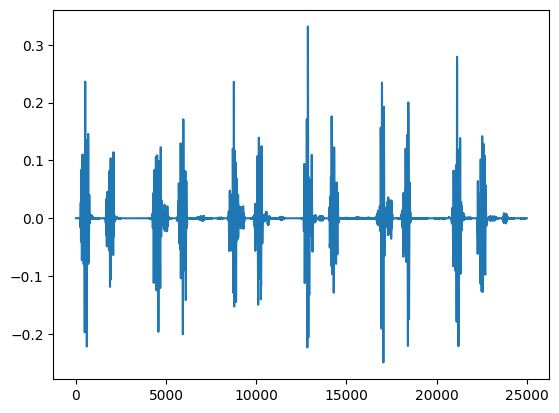

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (4):


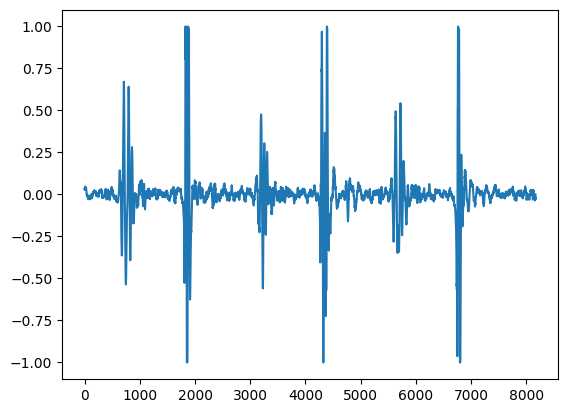

filtered audio (4):


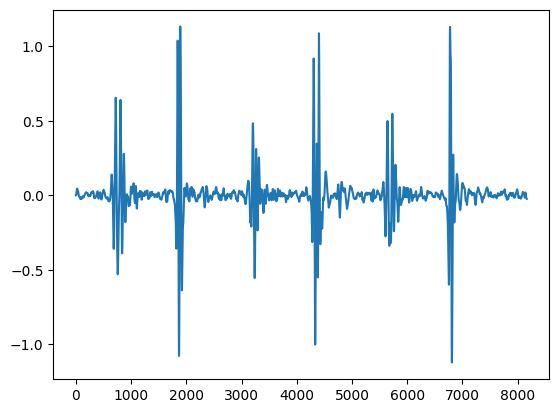

filtered audio (noise_reduction(); image 4):


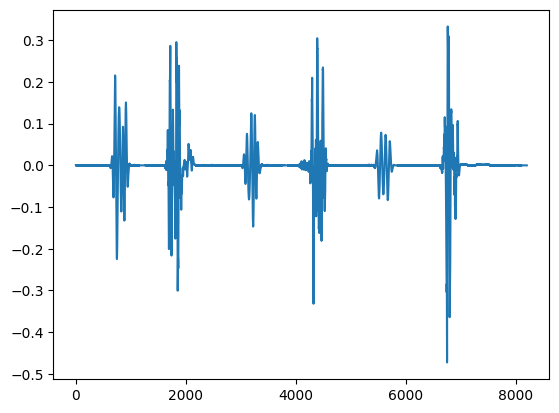

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (5):


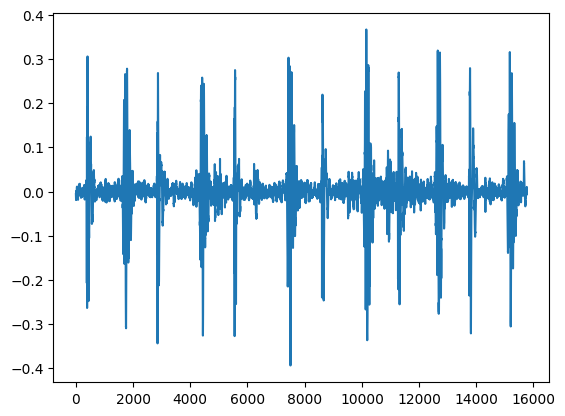

filtered audio (5):


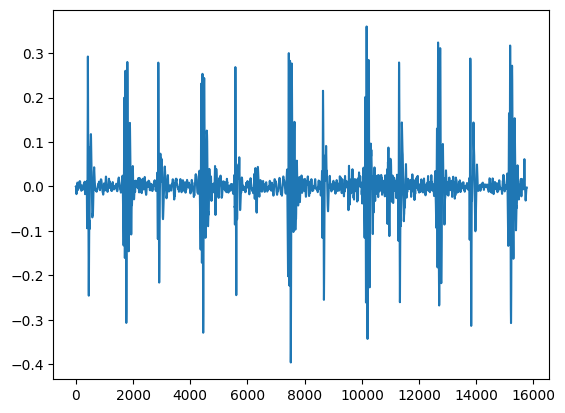

filtered audio (noise_reduction(); image 5):


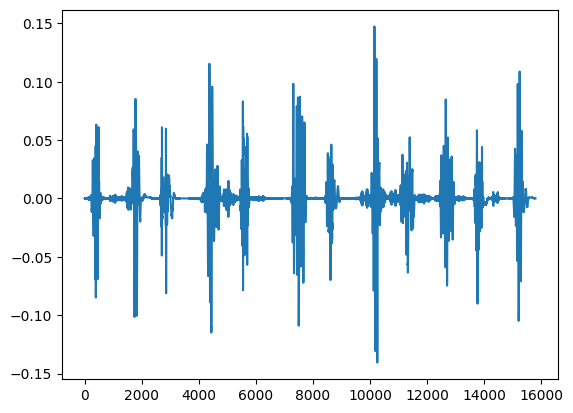

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (6):


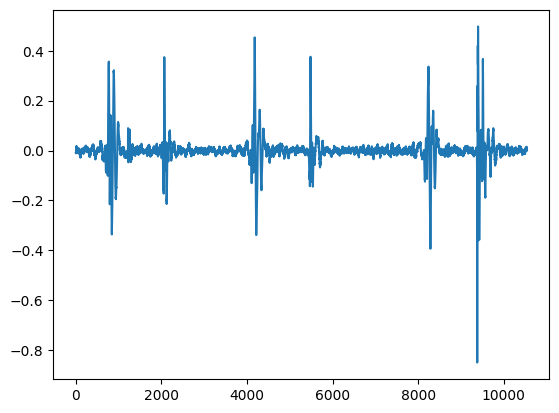

filtered audio (6):


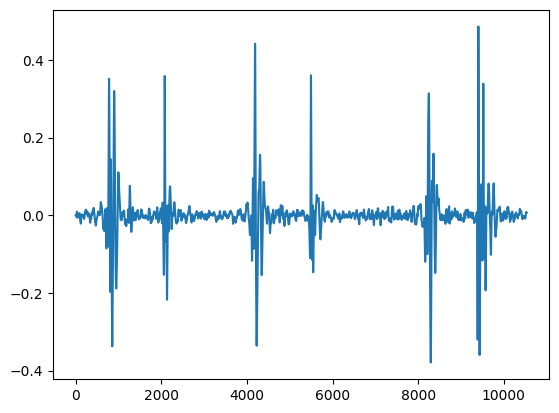

filtered audio (noise_reduction(); image 6):


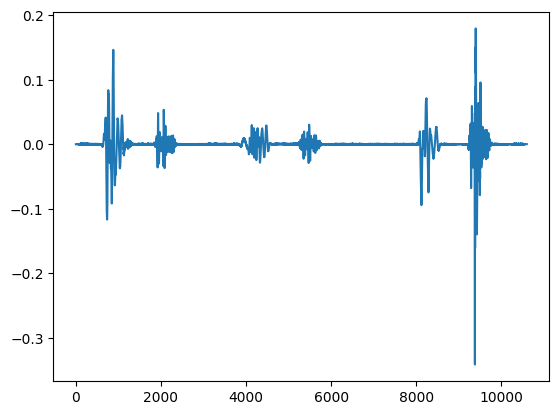

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (7):


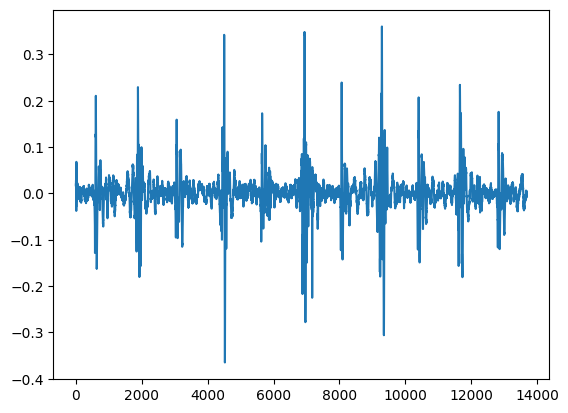

filtered audio (7):


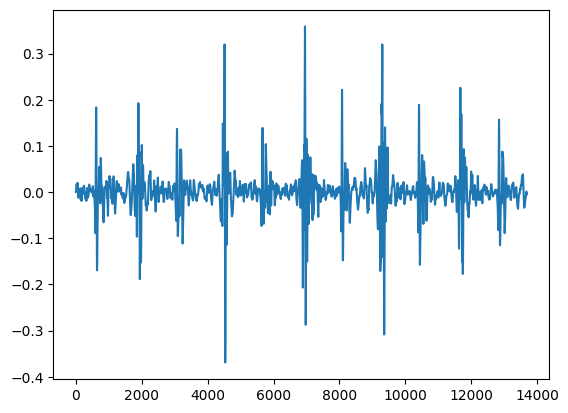

filtered audio (noise_reduction(); image 7):


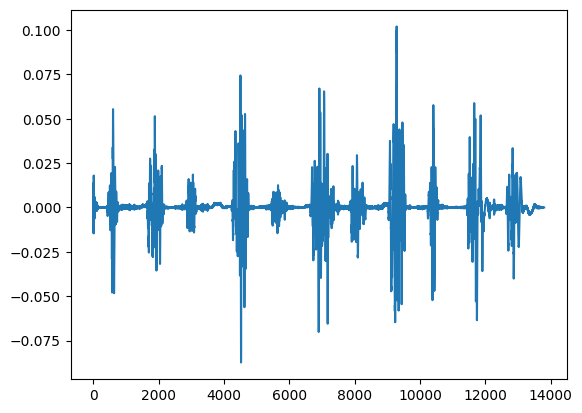

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (8):


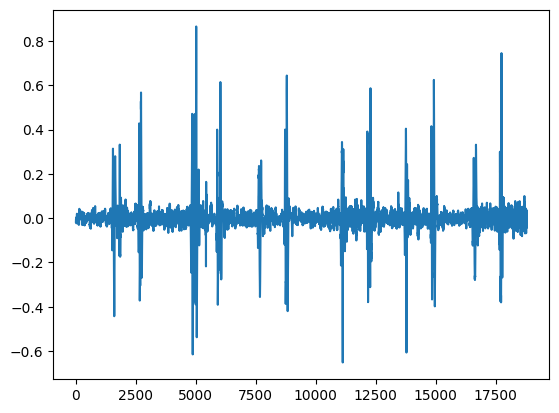

filtered audio (8):


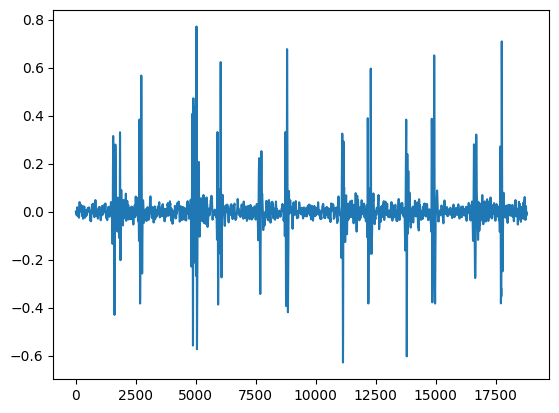

filtered audio (noise_reduction(); image 8):


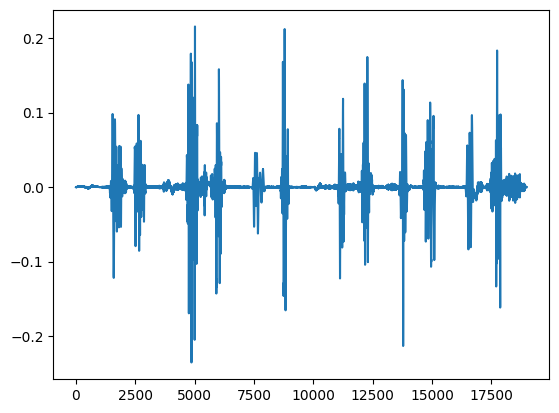

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (9):


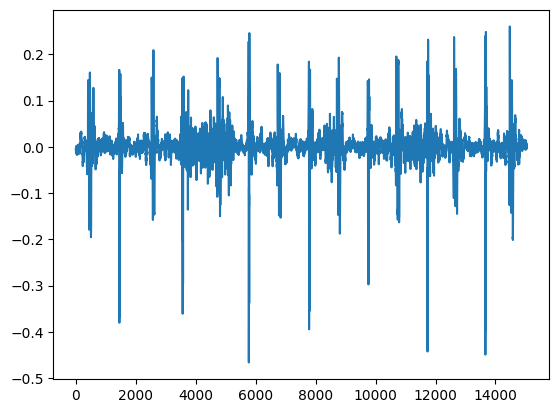

filtered audio (9):


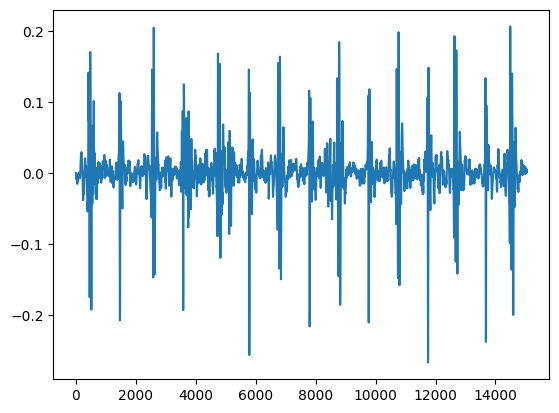

filtered audio (noise_reduction(); image 9):


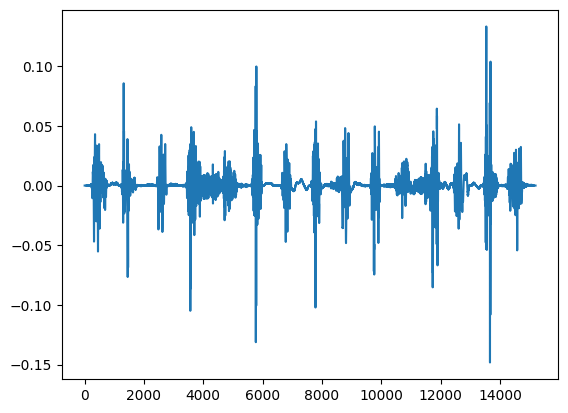

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (10):


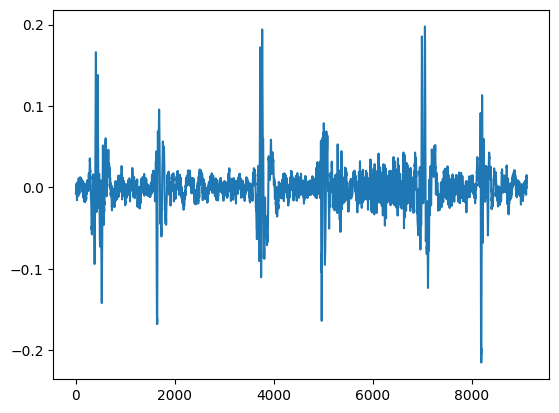

filtered audio (10):


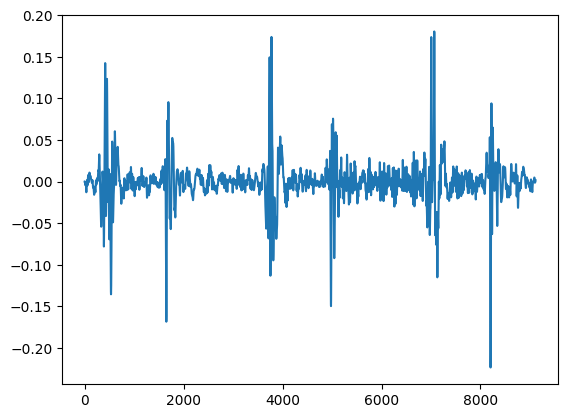

filtered audio (noise_reduction(); image 10):


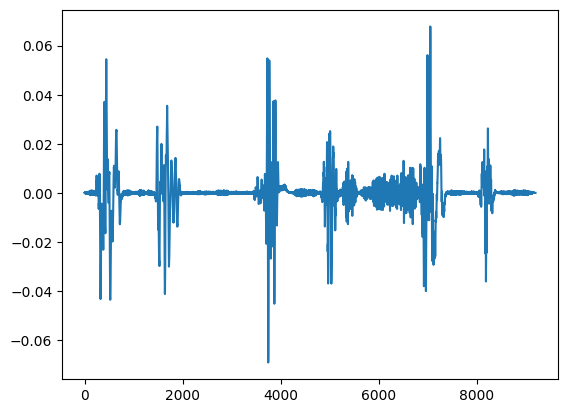

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (11):


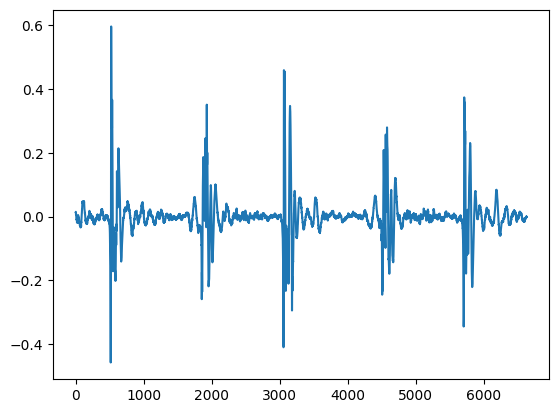

filtered audio (11):


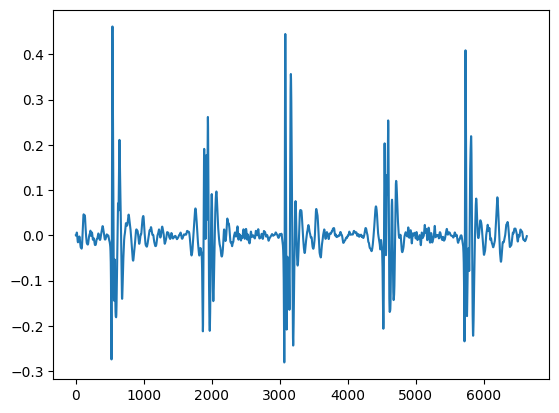

filtered audio (noise_reduction(); image 11):


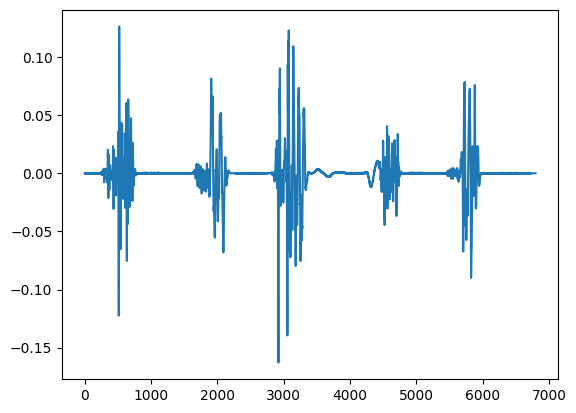

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (12):


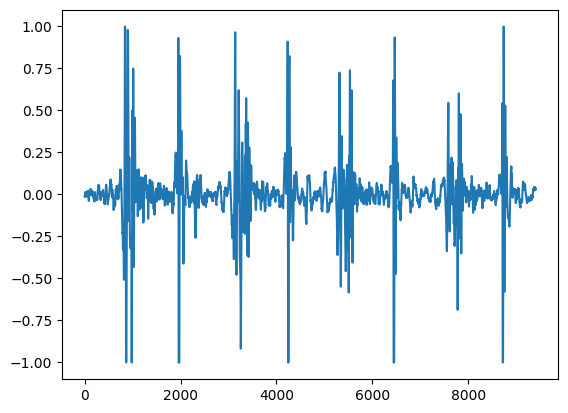

filtered audio (12):


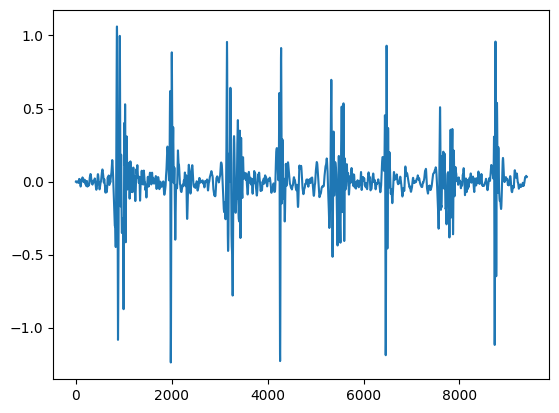

filtered audio (noise_reduction(); image 12):


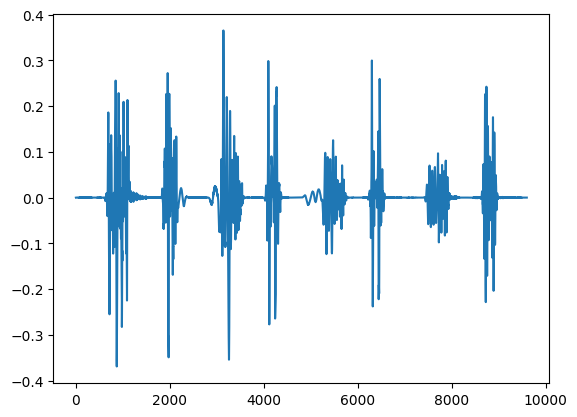

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (13):


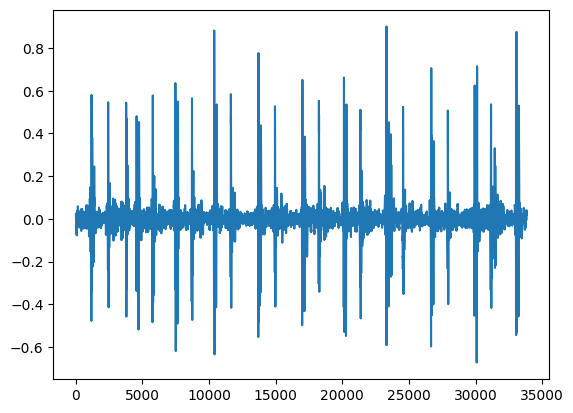

filtered audio (13):


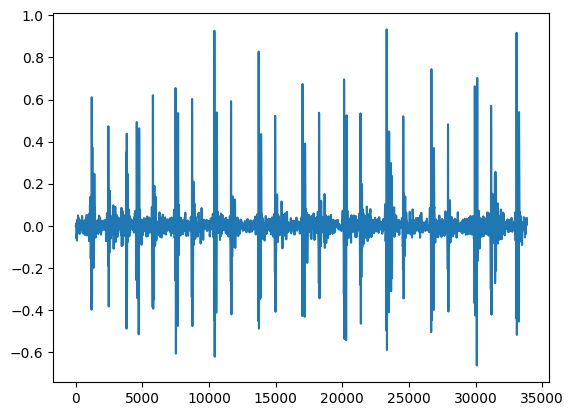

filtered audio (noise_reduction(); image 13):


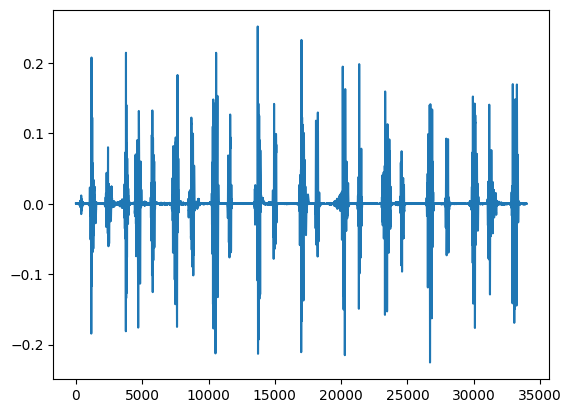

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (14):


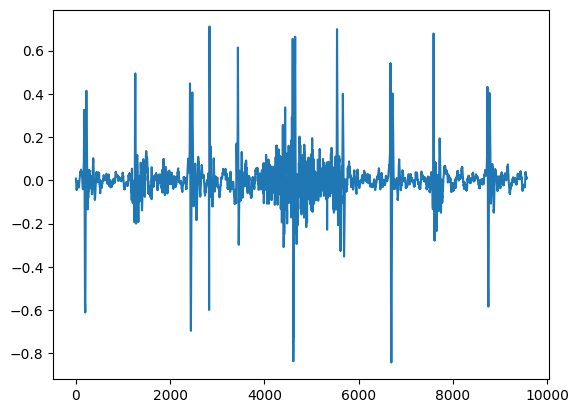

filtered audio (14):


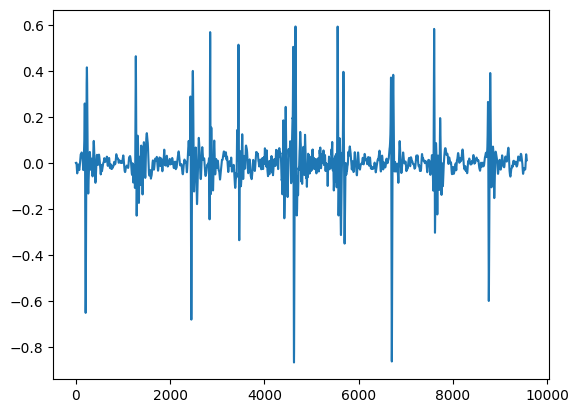

filtered audio (noise_reduction(); image 14):


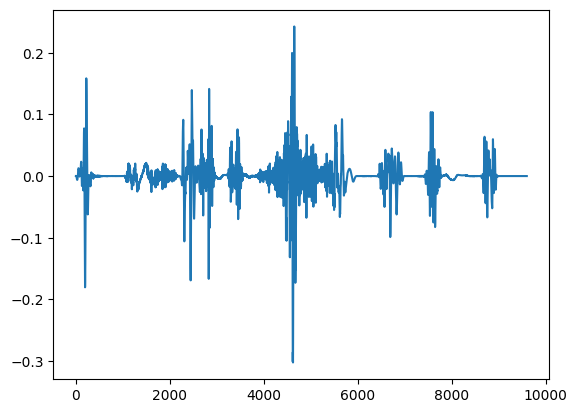

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (15):


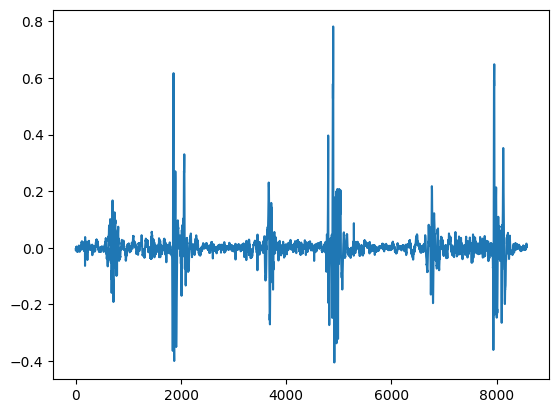

filtered audio (15):


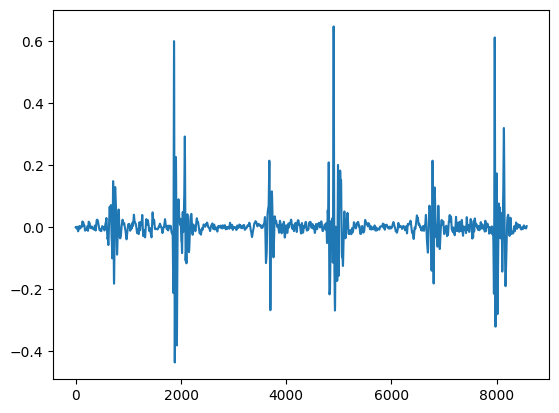

filtered audio (noise_reduction(); image 15):


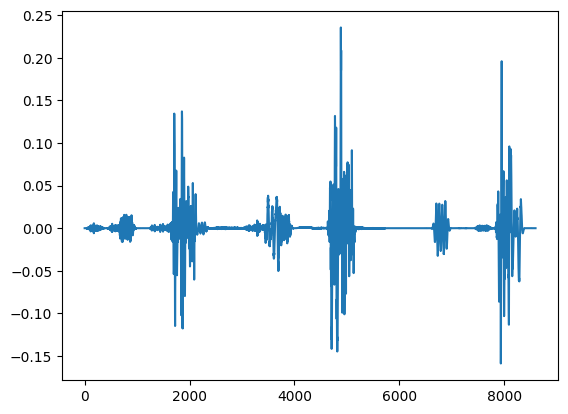

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (16):


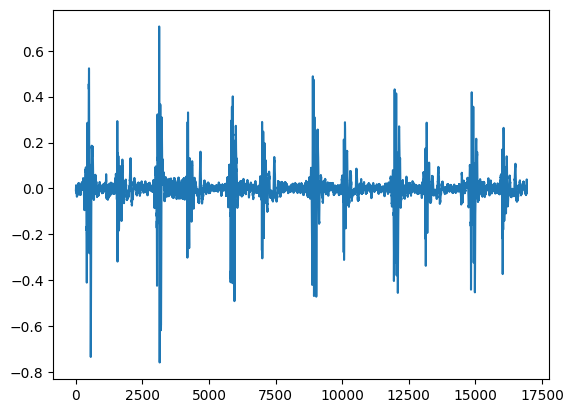

filtered audio (16):


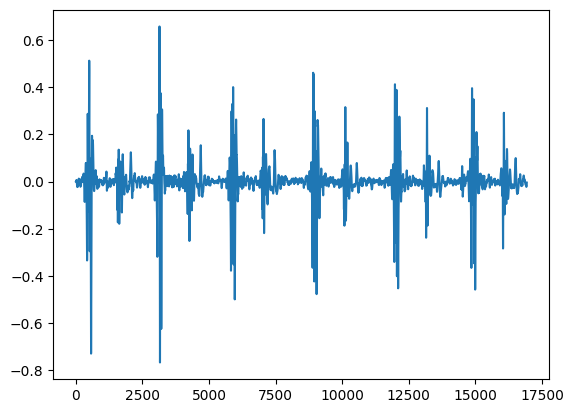

filtered audio (noise_reduction(); image 16):


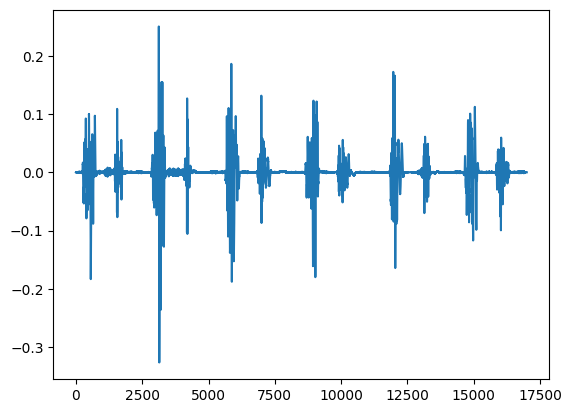

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (17):


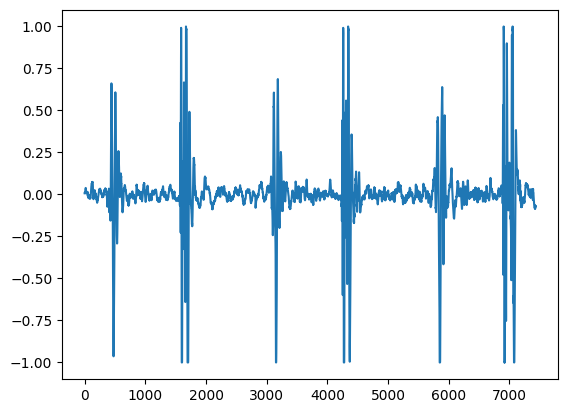

filtered audio (17):


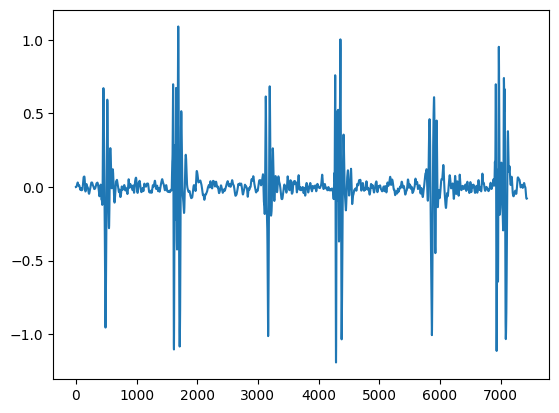

filtered audio (noise_reduction(); image 17):


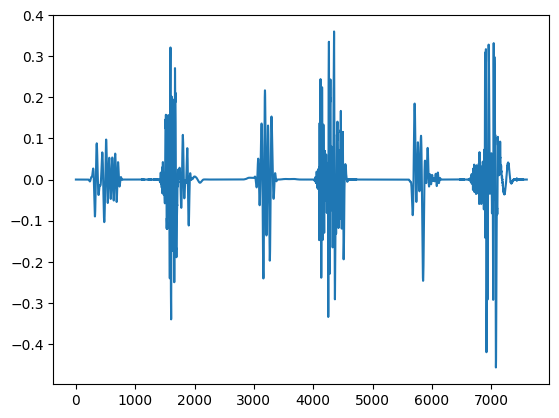

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (18):


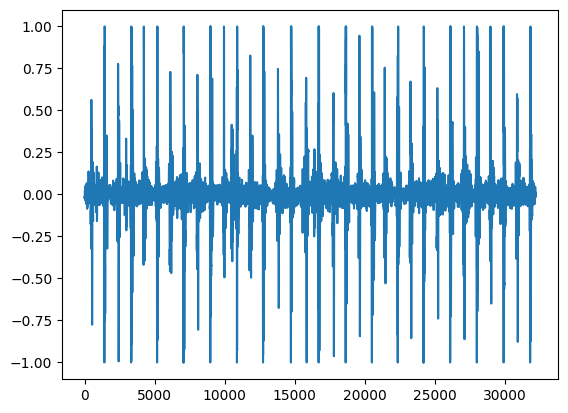

filtered audio (18):


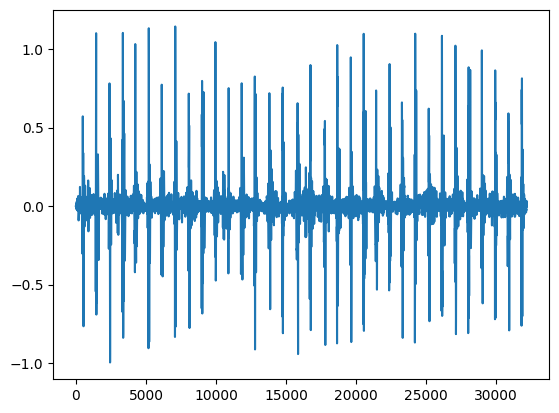

filtered audio (noise_reduction(); image 18):


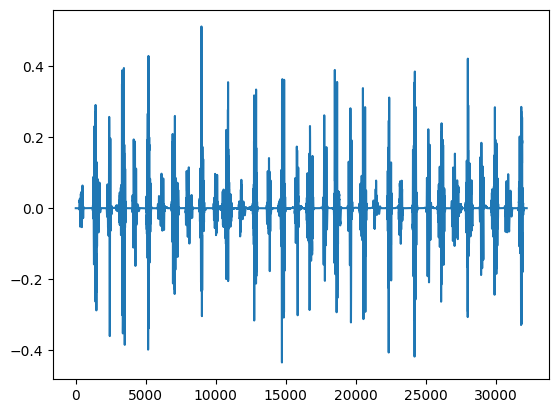

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (19):


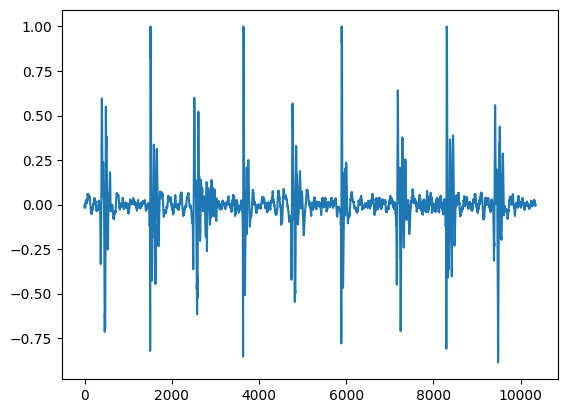

filtered audio (19):


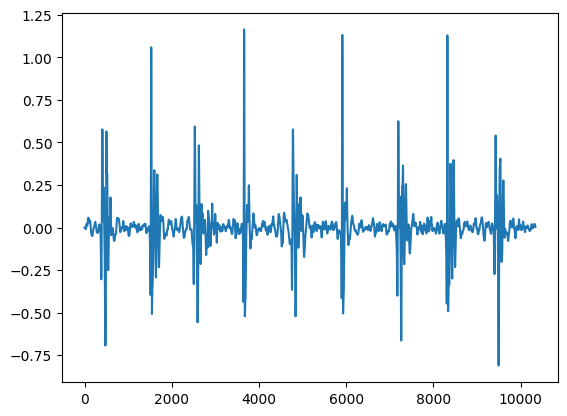

filtered audio (noise_reduction(); image 19):


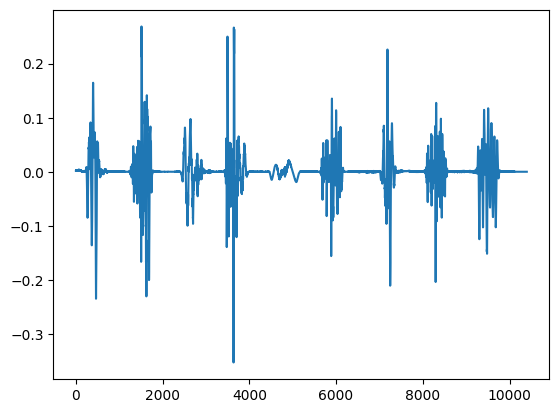

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (20):


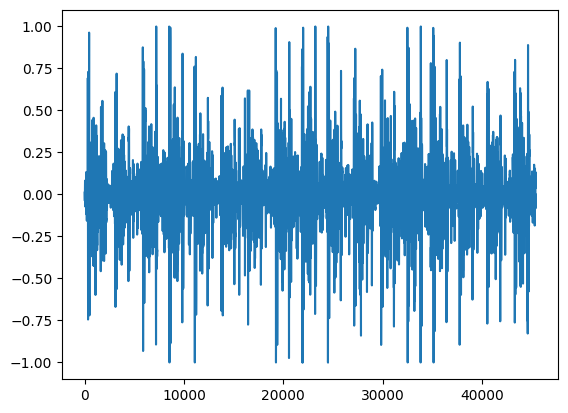

filtered audio (20):


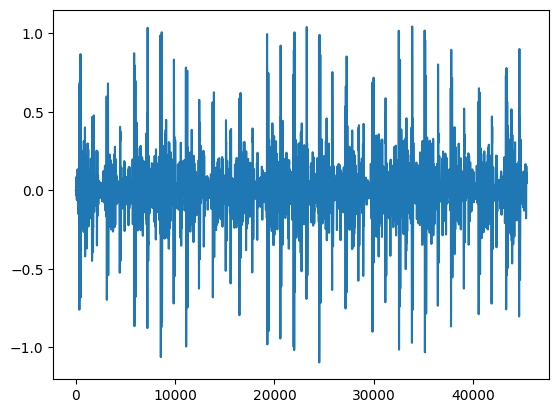

filtered audio (noise_reduction(); image 20):


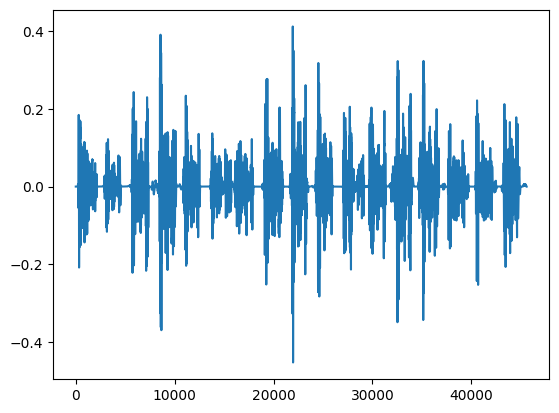

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (21):


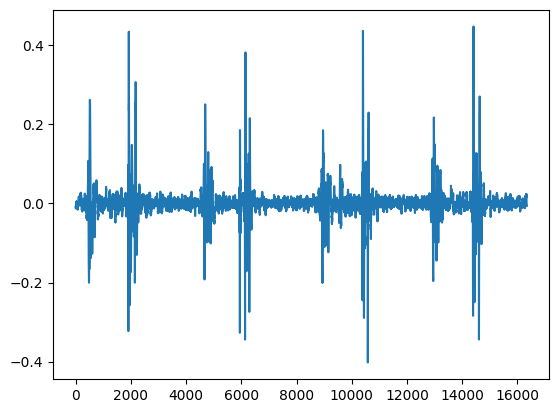

filtered audio (21):


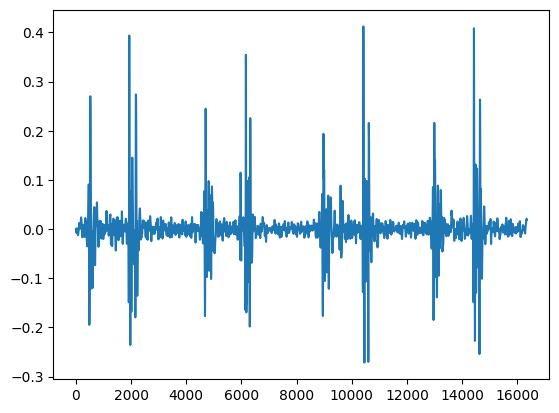

filtered audio (noise_reduction(); image 21):


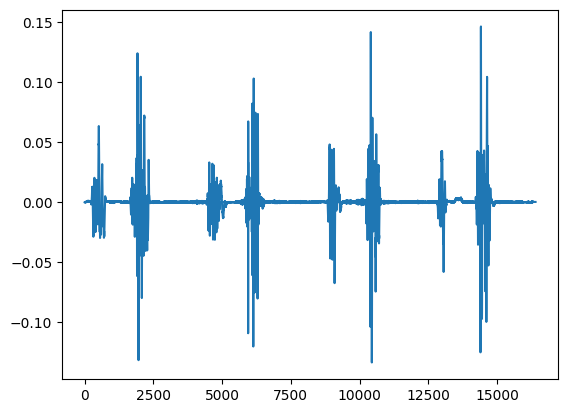

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (22):


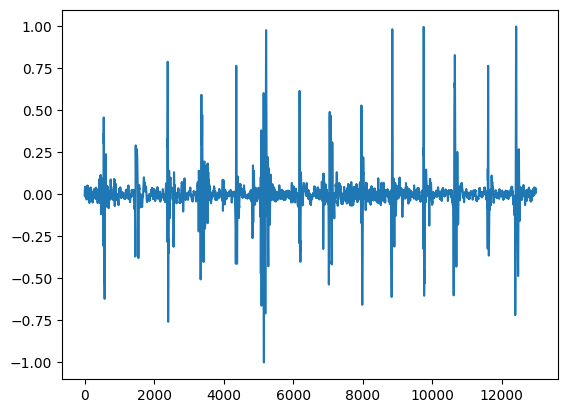

filtered audio (22):


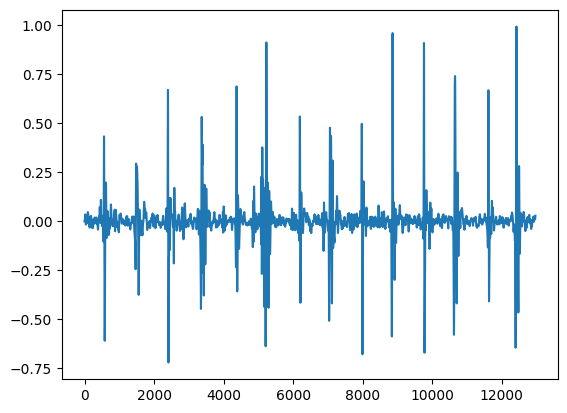

filtered audio (noise_reduction(); image 22):


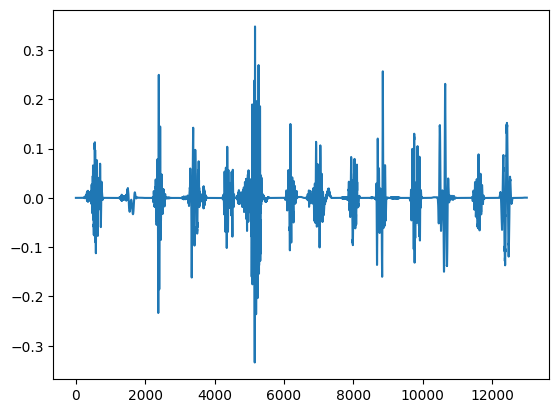

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (23):


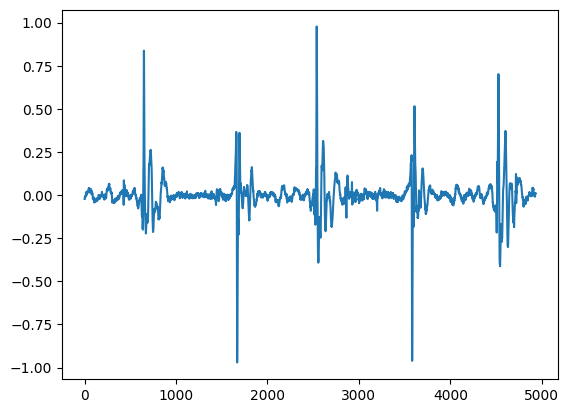

filtered audio (23):


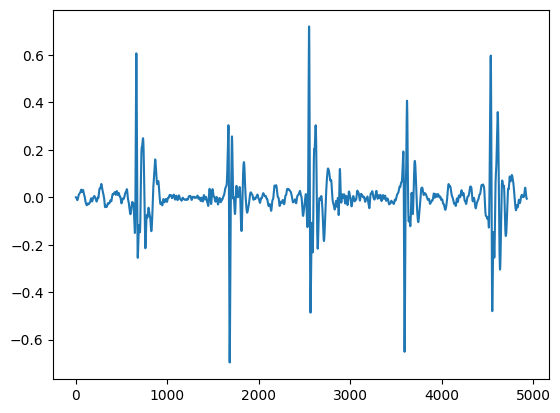

filtered audio (noise_reduction(); image 23):


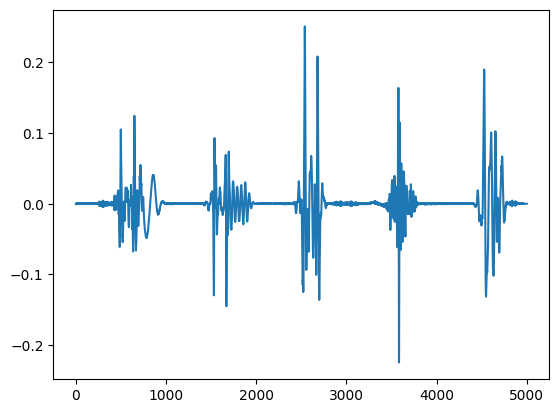

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (24):


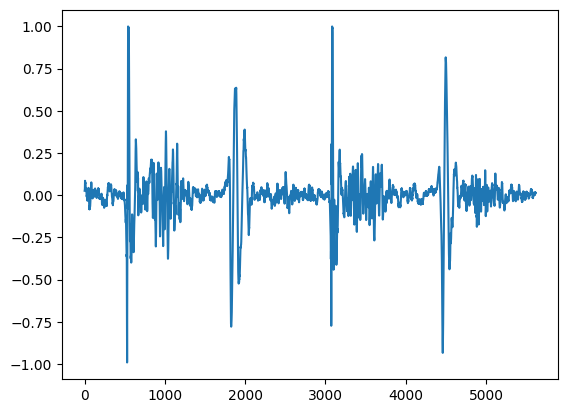

filtered audio (24):


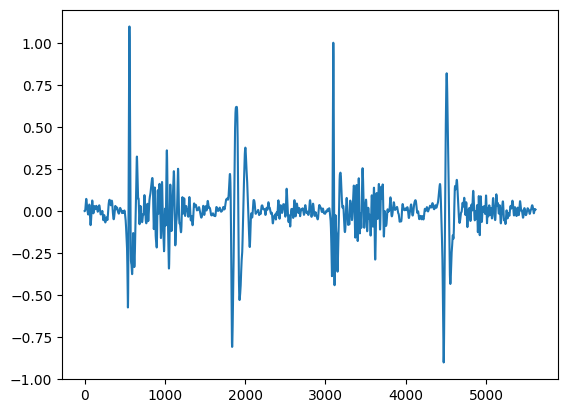

filtered audio (noise_reduction(); image 24):


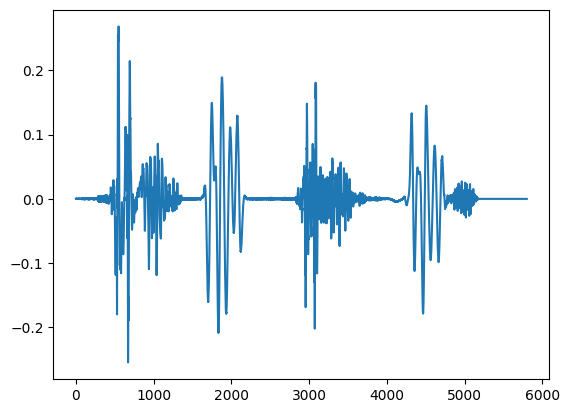

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (25):


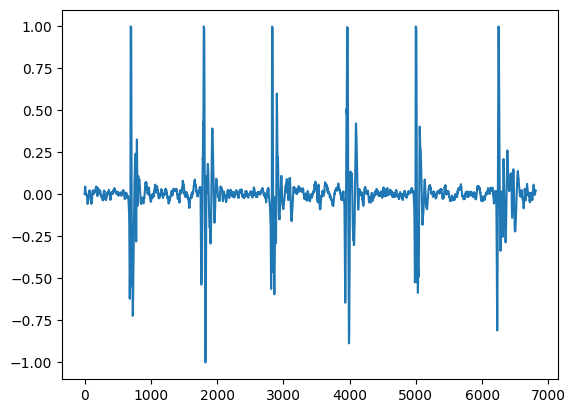

filtered audio (25):


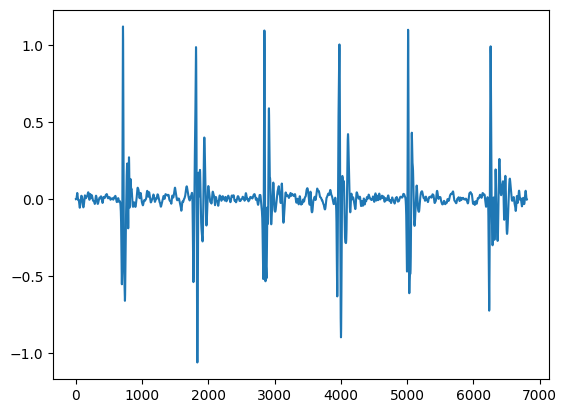

filtered audio (noise_reduction(); image 25):


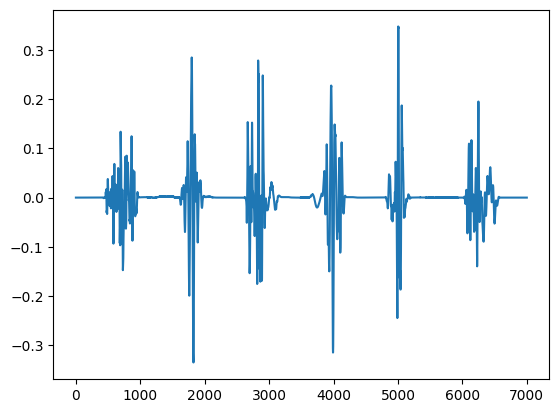

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (26):


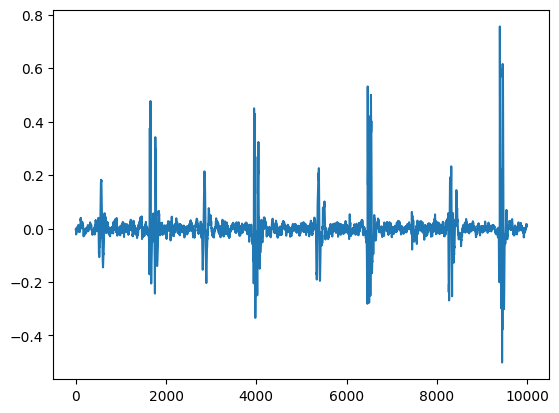

filtered audio (26):


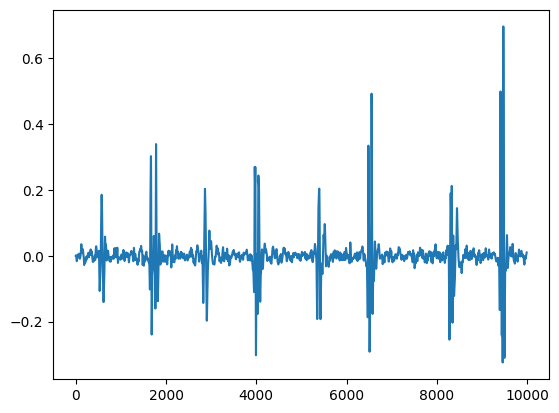

filtered audio (noise_reduction(); image 26):


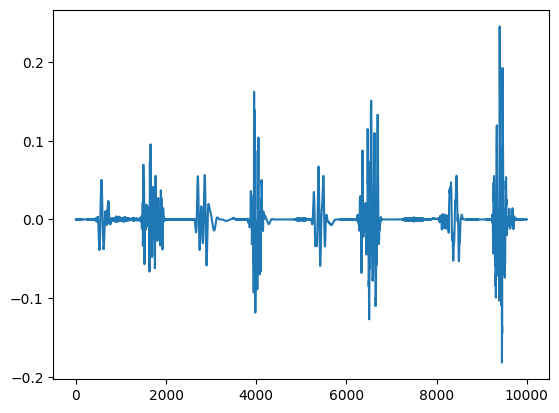

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (27):


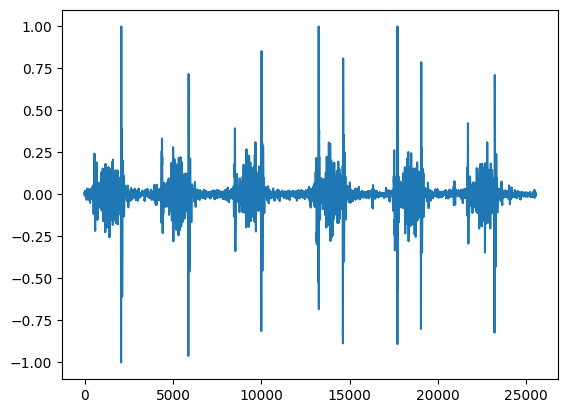

filtered audio (27):


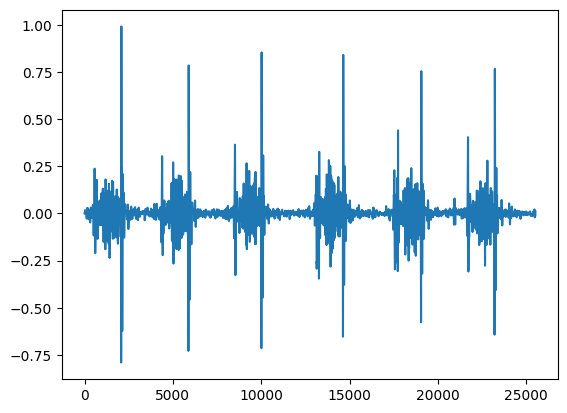

filtered audio (noise_reduction(); image 27):


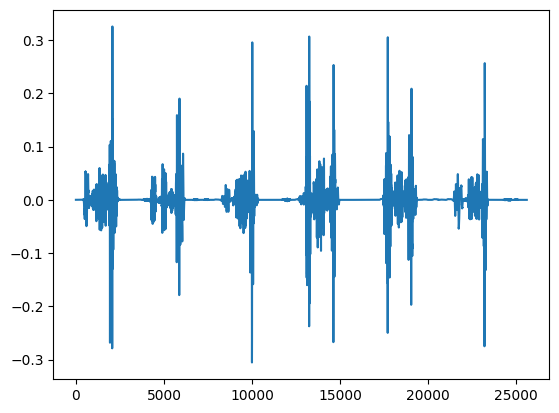

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (28):


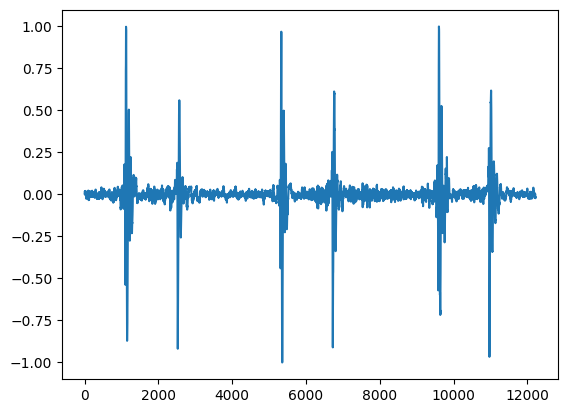

filtered audio (28):


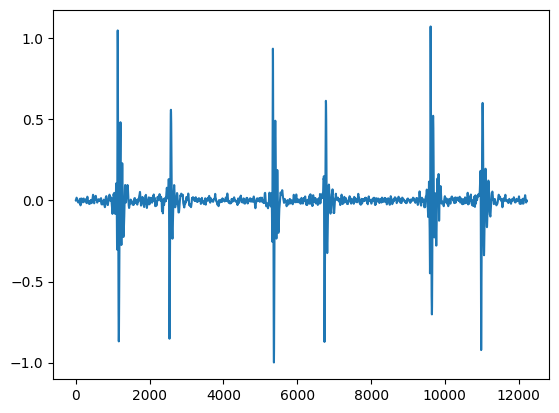

filtered audio (noise_reduction(); image 28):


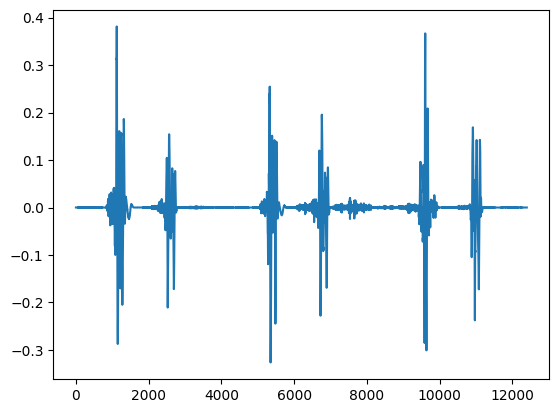

DATASET B, UNFILTERED AND FILTERED PLOTS
unfiltered audio (29):


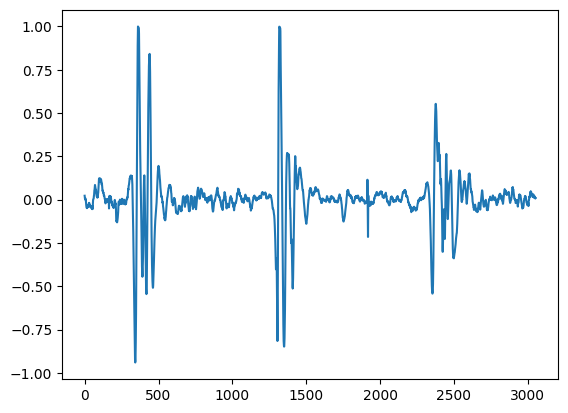

filtered audio (29):


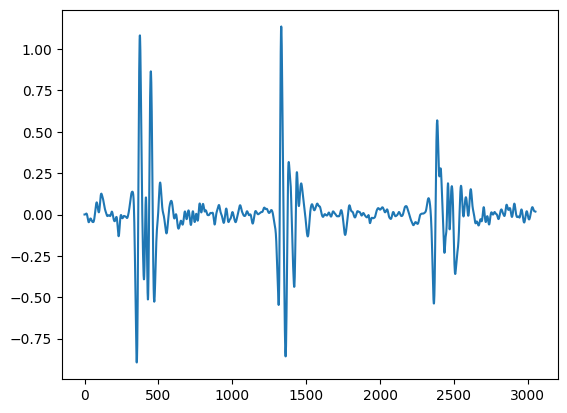

filtered audio (noise_reduction(); image 29):


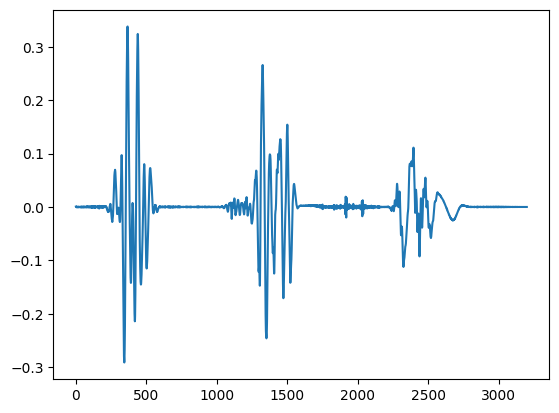

In [41]:
#### DATASET B, UNFILTERED AND FILTERED DATA
for i, signal_path in enumerate(paths_train[:30]):
  audio_data, sample_rate = librosa.load(signal_path, sr=None)
  filtered_audio = apply_lowpass_filter(audio_data, sample_rate)
  # plt.scatter(np.arange(len(audio_data))//sample_rate, audio_data)
  print("DATASET B, UNFILTERED AND FILTERED PLOTS")
  print(f"unfiltered audio ({i}):")
  plt.plot(audio_data)
  plt.show()
  print(f"filtered audio ({i}):")
  plt.plot(filtered_audio)
  plt.show()
  print(f"filtered audio (noise_reduction(); image {i}):")
  plt.plot(noise_reduction(audio_data, sample_rate))
  plt.show()

### Functions from my audio project

In [9]:
# Preprocessing
def preprocess_audio(audio_signal, sample_rate):
    # Noise reduction (spectral subtraction)
    denoised_signal = noise_reduction(audio_signal, sample_rate)

    # Normalize the audio signal
    normalized_signal = librosa.util.normalize(denoised_signal)
    return normalized_signal

label: normal


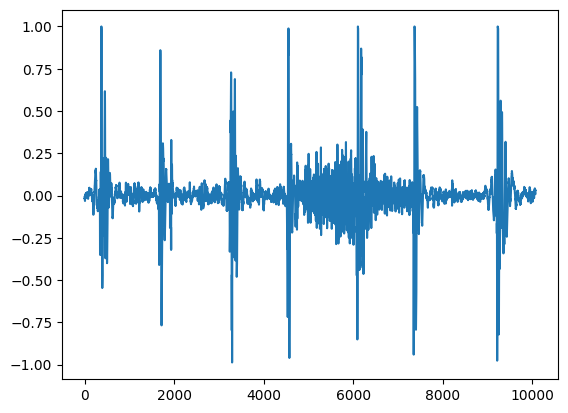

label: normal


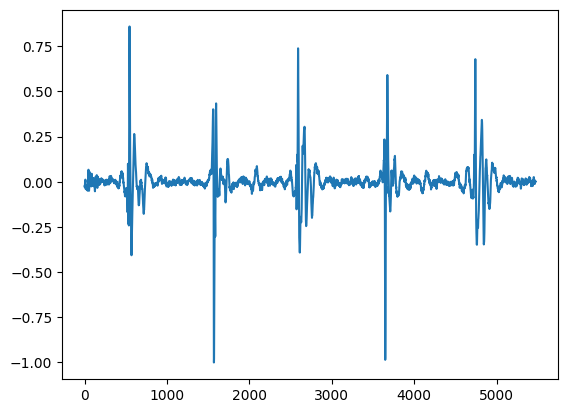

label: murmur


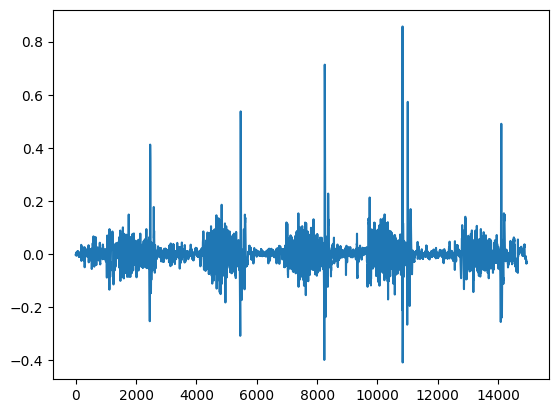

label: murmur


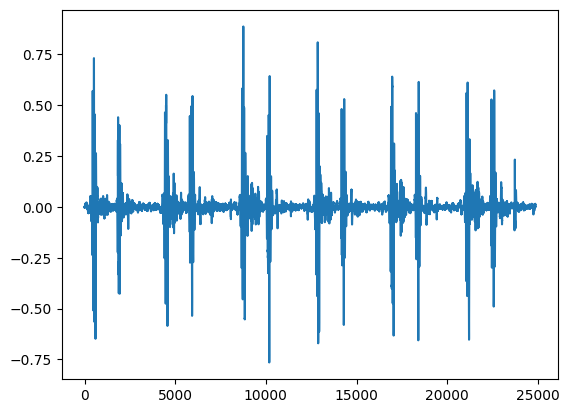

label: normal


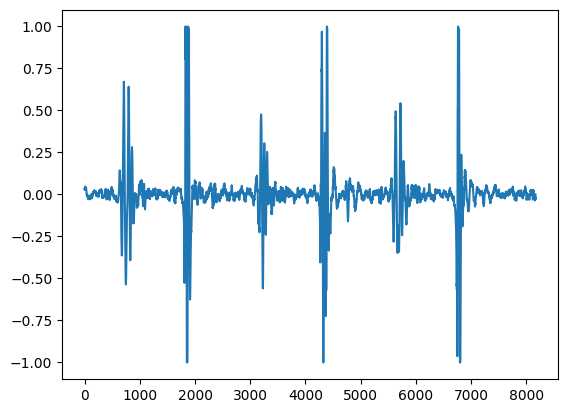

label: extrastole


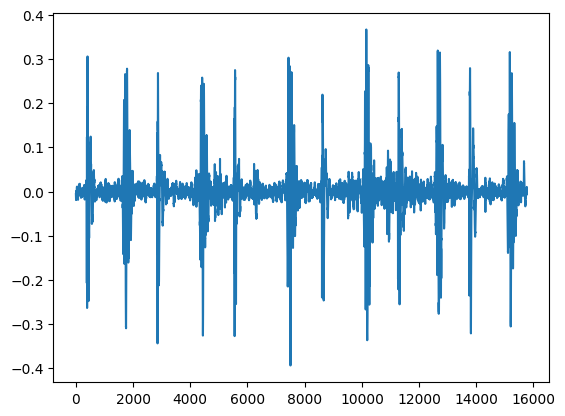

label: normal


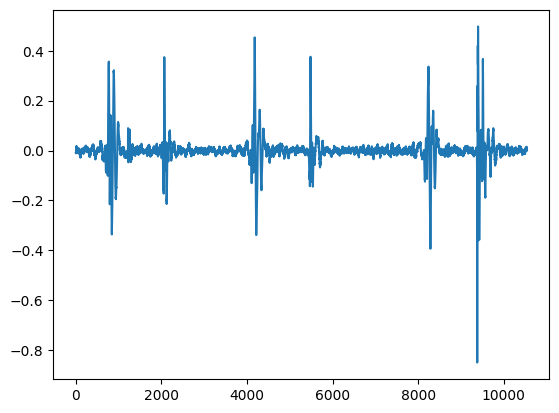

label: normal


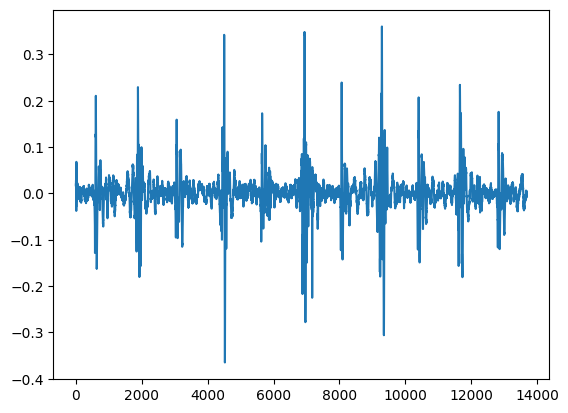

label: normal


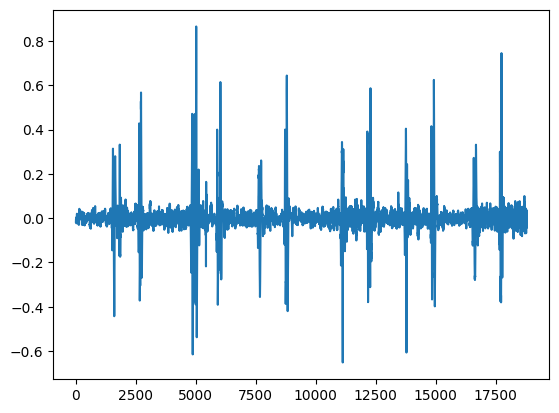

label: normal


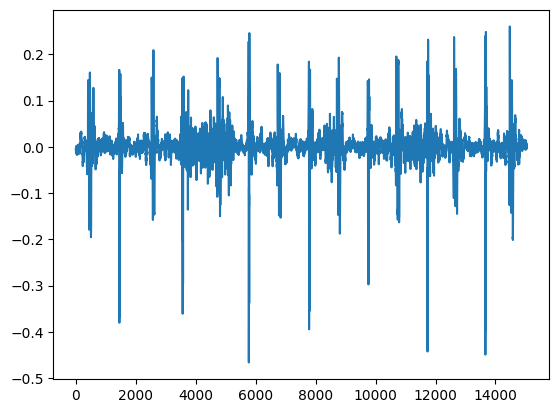

In [17]:
#### trying using Travis' butter filters***** it worked at first but now for some reason it doesn't
for signal_path, label in zip(paths_train[:10], labels_train[:10]):
  print("label:", label)
  audio_data, sample_rate = librosa.load(signal_path, sr=None)
  filtered_audio = noise_reduction(audio_data, sample_rate)
  # plt.scatter(np.arange(len(audio_data))//sample_rate, audio_data)
  plt.plot(audio_data)
  display(Audio(audio_data,rate=sample_rate))
  plt.show()

In [11]:
# Feature Extraction
def extract_features(audio_signal, sample_rate):
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio_signal, sr=sample_rate)

    # Extract spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=audio_signal, sr=sample_rate)
    spectral_flux = librosa.onset.onset_strength(y=audio_signal, sr=sample_rate)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_signal, sr=sample_rate)

    # Compute STFT
    stft = librosa.stft(audio_signal)

    # (Optional) Compute CWT
    # cwt = signal.cwt(audio_signal, signal.ricker, np.arange(1, 31))

    return mfccs, spectral_centroid, spectral_flux, spectral_rolloff, stft



In [12]:
# output - features that will be input to peak detection algorithm
mfccs, spectral_centroid, spectral_flux, spectral_rolloff, stft = extract_features(audio_signal, sample_rate)

NameError: ignored

---
XXXXXXXXXXXXX

### Cardiac Specific (not sure if these work, but looking for S1 and S2 peaks, and then segmenting accordingly?)

made peak detection to use the extracted features from above

In [ ]:
def peak_detection(audio_signal, sample_rate, features):
    # Calculate the onset envelope
    onset_env = librosa.onset.onset_strength(y=audio_signal, sr=sample_rate)

    # Detect the peaks in the onset envelope
    peaks, _ = signal.find_peaks(audio_signal, distance=sample_rate//8)

    # Separate the detected peaks into S1 and S2 sounds based on their amplitude
    peak_amplitudes = audio_signal[peaks]
    median_amplitude = np.median(peak_amplitudes)

    s1_locs = peaks[peak_amplitudes >= median_amplitude]
    s2_locs = peaks[peak_amplitudes < median_amplitude]

    return s1_locs, s2_locs

In [ ]:
s1_locs, s2_locs = peak_detection(preprocessed_audio, sample_rate, (mfccs, spectral_centroid, spectral_flux, spectral_rolloff))

S1 locations: [  2189  39941 149196 187544 226313 261251 297924 332718]
S2 locations: [ 25678  76511 115307 137458 173388 247742 285246 318903]


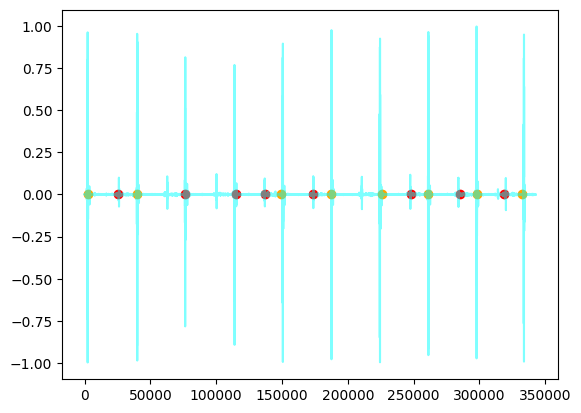

In [ ]:
print("S1 locations:", s1_locs)
print("S2 locations:", s2_locs)

plt.plot(audio_signal, alpha=0.5, c='cyan')
plt.scatter(s1_locs, np.zeros(len(s1_locs)), c='orange')
plt.scatter(s2_locs, np.zeros(len(s2_locs)), c='red')

In [ ]:
def segmentation(audio_signal, s1_locs, s2_locs, sample_rate):
    segments = []
    s1_s2_pairs = zip(s1_locs, s2_locs)

    for s1, s2 in s1_s2_pairs:
        # Check if the next S1 location is in the list
        next_s1_index = np.where(s1_locs == s1)[0][0] + 1
        if next_s1_index < len(s1_locs):
            next_s1 = s1_locs[next_s1_index]
            cardiac_cycle = audio_signal[s1:next_s1]
            segments.append(cardiac_cycle)
    
    return segments

In [ ]:
segments = segmentation(audio_signal, s1_locs, s2_locs, sample_rate)

Number of segments: 13


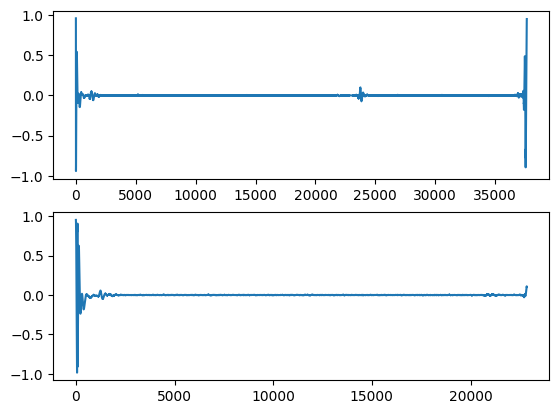

In [ ]:
print("Number of segments:", len(segments))

fig,axs = plt.subplots(nrows=2, ncols=1)
axs[0].plot(segments[0])
axs[1].plot(segments[1])

### To consider duration (modified cardiac functions from above) 

modified peak detection for duration

In [ ]:
def cardiac_cycle_detection(audio_signal, sample_rate):
    # Calculate the onset envelope
    onset_env = librosa.onset.onset_strength(y=audio_signal, sr=sample_rate)

    # Detect the peaks in the onset envelope
    peaks, _ = signal.find_peaks(onset_env, distance=sample_rate // 4)

    # Separate the detected peaks into S1 and S2 sounds based on their amplitude
    peak_amplitudes = onset_env[peaks]
    median_amplitude = np.median(peak_amplitudes)

    s1_locs = peaks[peak_amplitudes >= median_amplitude]
    s2_locs = peaks[peak_amplitudes < median_amplitude]

    # Calculate the duration of cardiac cycles (using S1 locations)
    cardiac_cycle_durations = np.diff(s1_locs)

    return s1_locs, s2_locs, cardiac_cycle_durations

modified segmentation to include clip length and hanning window

In [ ]:
def cardiac_cycle_segmentation(audio_signal, s1_locs, s2_locs, sample_rate, clip_duration=1):
    clip_length = sample_rate * clip_duration
    segments = []

    for s1, s2 in zip(s1_locs, s2_locs):
        # Check if the next S1 location is in the list
        next_s1_index = np.where(s1_locs == s1)[0][0] + 1
        if next_s1_index < len(s1_locs):
            next_s1 = s1_locs[next_s1_index]

            # Calculate the start and end positions of the 1-second audio clip
            clip_start = s1
            clip_end = min(s1 + clip_length, next_s1)

            # Extract the audio clip
            audio_clip = audio_signal[clip_start:clip_end]

            # Apply a windowing function (e.g., Hanning) to minimize discontinuities
            window = np.hanning(len(audio_clip))
            audio_clip = audio_clip * window

            segments.append(audio_clip)

    return segments

In [ ]:
s1_locs, s2_locs, cardiac_cycle_durations = cardiac_cycle_detection(audio_signal, sample_rate)
segments = cardiac_cycle_segmentation(audio_signal, s1_locs, s2_locs, sample_rate)

print("Number of segments:", len(segments))

TypeError: ignored